In [1]:
import os
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import csv
import gzip
import anndata as ad
from pathlib import Path
import glob
from sklearn.preprocessing import StandardScaler

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.8.0
scanpy      1.9.3
-----
MulticoreTSNE               NA
PIL                         9.1.0
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cloudpickle                 2.1.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.9.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.8.2
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.1
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
jinja2                      3.0.3
joblib   

In [ ]:
pwd
#3073 tried seemed to have problem of log as it warned that it was logged already but how???


In [4]:
def process(sample):

    # STEP 1 -> set corresponding folders which the results of each specimen are written to
    output_folder = "/Users/lidiayung/project/specimens"
    resource_folder = "/Users/lidiayung/project/resource/GSE174554_RAW/"
 
    matrix_path = glob.glob(f"{resource_folder}/GSM*_{sample}_matrix.mtx.gz")[0]
    features_path = glob.glob(f"{resource_folder}/GSM*_{sample}_features.tsv.gz")[0]
    barcodes_path = glob.glob(f"{resource_folder}/GSM*_{sample}_barcodes.tsv.gz")[0]


    output_path = os.path.join(output_folder, sample)
    
    if len(features_path) == 0:
        print(f"No document found for sample {sample}")

    # End of Step 1

    # STEP 2 -> creat output documents
    # path to unfiltered loom file (this will be created in the optional steps below)

    f_loom_path_unfilt = f"{output_path}/1unfiltered.loom" 
    f_loom_path_scenic = f"{output_path}/1filtered_scenic.loom"
    f_anndata_path = f"{output_path}/1anndata.h5ad"
    f_pyscenic_output = f"{output_path}/1output.loom"
    f_final_loom = f"{output_path}/1scenic_integrated-output.loom"

    # End of Step 2

    # Step 3-> read data into anndata
    mat = scipy.io.mmread(matrix_path)
    feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
    gene_names = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
    feature_types = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
    barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, mode="rt"), delimiter="\t")]
    matrix = pd.DataFrame.sparse.from_spmatrix(mat)
    matrix.columns = barcodes
    matrix=matrix.transpose() 
    matrix.columns = gene_names

    # convert the index and columns to DataFrame objects
    obs_df = matrix.index.to_frame(index=False)
    var_df = matrix.columns.to_frame(index=False)

    adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)


    row_attrs = {  "Gene": np.array(var_df[0]) ,}
    col_attrs = { "CellID":  np.array(matrix.index) , 
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    }
    lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )   

    # End of Step 3

    #Step 4-> Filtering cells that have >2.5% mitochondrial read counts and <200 expressed genes

    adata = sc.read_loom( f_loom_path_unfilt )
    nCountsPerGene = np.sum(adata.X, axis=0)
    nCellsPerGene = np.sum(adata.X>0, axis=0)
        
    nCells=adata.X.shape[0]

    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    sc.pp.filter_cells(adata, min_genes=200 )
    adata = adata[adata.obs['percent_mito'] <=0.025, :]
    #End of Step 4
    print(adata.obs.index)

    #Step 5 -> Read filtered data
    adata.write( f_anndata_path )
    # create basic row and column attributes for the loom file:
    row_attrs = {    "Gene": np.array(adata.var_names) ,}
    col_attrs = {
     "CellID": np.array(adata.obs_names) ,
     "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
     "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
     }
    lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)
    
    #End of Step 5
    
    #Step 6 -> integrate metadata
    file = "/Users/lidiayung/project/resource/GSE174554_RAW/GSE174554_Tumor_normal_metadata.txt"
    metadata= pd.read_csv(file,sep=' ')
    metadata.head()
    #End of Step 6

    #Step 7 -> Calculate percentage and return the value from both pre and post data
    new_df = metadata[metadata["Sample#"] == sample].copy()
    new_df['Barcode'] = new_df['Barcode'].astype(str)
    print(new_df)

    intersection_barcodes = set(new_df['Barcode']).intersection(adata.obs.index)
    tumor = new_df[new_df['Barcode'].isin(intersection_barcodes) & (new_df['Tumor_Normal_annotation'] == 'Tumor')]
    print(tumor)
    percentage = "{:.2%}".format(len(tumor)/len(adata.obs.nUMI))
    #print("Percentage: {:.2%}".format(len(tumor)/len(adata.obs.nUMI)))
    post_filtering = f"{len(tumor)}/{len(adata.obs.nUMI) - len(tumor)}"
    
    print(f"{post_filtering}")
    
    tumor_obs = adata.obs.loc[adata.obs.index.isin(set(tumor['Barcode']))]
                                                   
    tumor_adata = adata[adata.obs.index.isin(tumor_obs.index)]

    # Filter to keep only tumor samples
    tumor_adata.write( f_anndata_path )
    print(tumor_adata)

    

In [5]:
process('SF2777')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_45717/3884576723.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGGGATCAC-1', 'AAACCCAGTCGATTTG-1', 'AAACCCAGTCGTCAGC-1',
       'AAACCCAGTTGTAAAG-1', 'AAACGAAGTAGACAAT-1', 'AAACGAATCGCAAGAG-1',
       'AAACGCTCAAGTCCCG-1', 'AAACGCTCATCCTCAC-1', 'AAACGCTGTCTATGAC-1',
       'AAAGAACAGGTCTTTG-1',
       ...
       'TTTGATCGTCCAATCA-1', 'TTTGGTTAGTAAGAGG-1', 'TTTGGTTCAGCAATTC-1',
       'TTTGGTTTCAGCAATC-1', 'TTTGTTGAGGTTCTTG-1', 'TTTGTTGAGTACCATC-1',
       'TTTGTTGCACTGGCCA-1', 'TTTGTTGGTACTCAAC-1', 'TTTGTTGTCCCAAGTA-1',
       'TTTGTTGTCGGATTAC-1'],
      dtype='object', name='CellID', length=3708)
       Sample#             Barcode Tumor_Normal_annotation
184620  SF2777  AAACGCTAGCTGTTAC-1                  Normal
184621  SF2777  AACCTTTTCACTCCGT-1                  Normal
184622  SF2777  AAGGTAATCCATTCAT-1                  Normal
184623  SF2777  ACACCAATCTACACTT-1                  Normal
184624  SF2777  ACACTGACACCAACAT-1                  Normal
...        ...                 ...                     ...
188798  SF2777  CCTGTTGCACGCA

In [126]:
to_finish_samples=['SF9372','SF4324','SF10857','SF11981',  'SF11873']
# no metadata 'SF11981'

In [8]:
v2 = ['SF9715v2','SF6118v2','SF12704']
process('SF6118v2')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/1486149274.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCACAATACCTG', 'AAACCCAGTTTACGAC', 'AAAGGGCGTGCACATT',
       'AAAGGGCTCGTGCGAC', 'AACAAGAGTAGTCGTT', 'AACCACAAGGCCTGAA',
       'AACCACACAATGTCAC', 'AACCATGTCACCCTGT', 'AACCCAAGTGGCTGAA',
       'AACGAAAAGTAGACCG',
       ...
       'TTGGGATAGCGAACTG', 'TTGGGATGTCGTTCAA', 'TTGGGATTCTGGGCGT',
       'TTGGGCGCACGGCACT', 'TTGGGCGTCCGACATA', 'TTGGGTATCATAGCAC',
       'TTGTTTGAGAGCAGCT', 'TTGTTTGTCTAGTGTG', 'TTTACCACAAATAGCA',
       'TTTCAGTTCGCGGACT'],
      dtype='object', name='CellID', length=490)
         Sample#           Barcode Tumor_Normal_annotation
167461  SF6118v2  ACTGTGATCCGGACGT                   Tumor
167462  SF6118v2  ATGCCTCAGCATGGGT                   Tumor
167463  SF6118v2  CACTGTCAGACATCCT                   Tumor
167464  SF6118v2  CCACCATTCGCTGATA                   Tumor
167465  SF6118v2  TACGGGCTCGATTTCT                   Tumor
...          ...               ...                     ...
168533  SF6118v2  TTGTTTGAGAGCAGCT                  Normal
168534  SF6

In [57]:
#updated
new_row = [{'Sample': 'SF9715v2', 'Post-filtering': '2536/1195','Percentage':'67.97','Age':'36','Sex':'M','Stage':'Recurrent','Pair#':'20'},
           {'Sample':  'SF12704', 'Post-filtering': '1189/639','Percentage':'65.04', 'Age':'51','Sex':'F','Stage':'Recurrent'},
           {'Sample':  'SF12704v2', 'Post-filtering': '1253/2919','Percentage':'30.03','Sex':'F','Stage':'Recurrent'},
           {'Sample':  'SF6118v2', 'Post-filtering':  '133/357','Percentage':'27.14','Age':'52','Sex':'M','Stage':'Recurrent','Pair#':'19'}]

In [104]:
new_row = [{'Sample': 'SF4324', 'Post-filtering': '886/2779','Percentage':'24.17'},
           {'Sample': 'SF11916', 'Post-filtering': '916/71','Percentage':'92.81'},
           {'Sample': 'SF11815', 'Post-filtering': '3060/272','Percentage':'91.83'},
           {'Sample': 'SF11873', 'Post-filtering': '166/2964','Percentage':'5.3'},'percentage':'70.625',
           'Stage'='Primary','Pair#':'10','Age':'55.0','Sex':'F']

In [ ]:
new_row = [{'Sample': 'SF10857', 'Post-filtering': '2094/142','Percentage':'93.65'}]

In [120]:
n_results[n_results['Sample']=='SF11873']

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
3,SF11873,166/2964,5.3,166,70.625,Primary,10.0,55.0,F


In [105]:
#n_results.update(new_row)

In [121]:
n_results[n_results['Sample']=='SF4324']

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
0,SF4324,886/2779,24.17,886,25.0,Primary,NaN,61.0,F


In [118]:
n_results= n_results.drop(20)

In [122]:
n_results[n_results['Sample']=='SF11916']

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
1,SF11916,916/71,92.81,916,91.666667,Primary,8.0,57.0,M


In [123]:
n_results[n_results['Sample']=='SF11815']

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
2,SF11815,3060/272,91.83,3060,96.875,Primary,NaN,83.0,F


In [101]:
n_results['Pair#'] = pd.to_numeric(n_results['Pair#'], errors='coerce')
paired_to_plot = n_results[n_results['Pair#'].notnull()]

paired_to_plot =paired_to_plot.sort_values('Pair#',ascending = True)

In [102]:
paired_to_plot.head(40)

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
25,SF10484,1449/1475,49.56,1449,50.000000,Recurrent,1.0,67.0,M
79,SF10441,466/640,42.13,466,40.000000,Recurrent,2.0,56.0,M
12,SF10099,437/116,79.02,437,56.250000,Primary,2.0,55.0,M
57,SF10565,245/2627,8.53,245,8.750000,Recurrent,3.0,45.0,F
27,SF11248,906/982,47.99,906,48.000000,Recurrent,4.0,52.0,F
13,SF10432,434/19,95.81,434,87.500000,Primary,4.0,50.0,F
76,SF10592,296/1037,22.21,296,23.000000,Primary,5.0,66.0,M
29,SF11857,157/3236,4.63,157,6.000000,Recurrent,5.0,69.0,M
55,SF11488,4257/155,96.49,4257,96.750000,Recurrent,6.0,60.0,F
15,SF11082,4021/111,97.31,4021,97.916667,Primary,6.0,59.0,F


In [103]:
paired_to_plot.tail(33)

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
71,SF6809,127/55,69.78,127,67.000000,Primary,21.0,57.0,M
23,SF6809,127/55,69.78,127,67.000000,Primary,21.0,57.0,M
47,SF7025,0/149,0.0,0,50.000000,Recurrent,21.0,58.0,M
48,SF7062,713/2413,22.81,713,23.000000,Recurrent,22.0,40.0,F
49,SF7388,2868/1659,63.35,2868,57.500000,Recurrent,23.0,60.0,M
72,SF7307,153/46,76.88,153,54.375000,Primary,23.0,60.0,M
24,SF7307,153/46,76.88,153,54.375000,Primary,23.0,60.0,M
60,SF12165,756/2381,24.1,756,24.000000,Recurrent,24.0,40.0,F
50,SF9510,756/4148,15.42,756,19.000000,Recurrent,25.0,73.0,M
73,SF9358,494/2616,15.88,494,16.000000,Primary,26.0,60.0,M


In [86]:
n_results= pd.read_pickle('/Users/lidiayung/github/notebooks/GBM/calculation/integrated_to_plot.pkl')
#n_results = n_results.append(new_row, ignore_index=True)

In [87]:
n_results.update(new_row)

In [88]:
n_results

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
0,SF4324,886/2779,24.17,215,25.000000,Primary,NaN,61.0,F
1,SF11916,916/71,92.81,111,91.666667,Primary,8,57.0,M
2,SF11815,3060/272,91.83,1120,96.875000,Primary,NaN,83.0,F
3,SF11873,166/2964,5.3,231,70.625000,Primary,10,55.0,F
4,SF2777,3323/385,89.62,3323,90.630000,Primary,11,29.0,F
...,...,...,...,...,...,...,...,...,...
79,SF10441,466/640,42.13,466,40.000000,Recurrent,2,56.0,M
80,SF9715v2,2536/1195,67.97,2536,NaN,Recurrent,20,36,M
81,SF12704,1189/639,65.04,1189,NaN,Recurrent,NaN,51,F
82,SF12704v2,1253/2919,30.03,1253,NaN,Recurrent,NaN,NaN,F


In [119]:
n_results['Sum'] = n_results['Post-filtering'].str.split('/').str[0]
n_results

,Sample,Post-filtering,Percentage,Sum,percentage,Stage,Pair#,Age,Sex
0,SF4324,886/2779,24.17,886,25.000000,Primary,NaN,61.0,F
1,SF11916,916/71,92.81,916,91.666667,Primary,8.0,57.0,M
2,SF11815,3060/272,91.83,3060,96.875000,Primary,NaN,83.0,F
3,SF11873,166/2964,5.3,166,70.625000,Primary,10.0,55.0,F
4,SF2777,3323/385,89.62,3323,90.630000,Primary,11.0,29.0,F
...,...,...,...,...,...,...,...,...,...
79,SF10441,466/640,42.13,466,40.000000,Recurrent,2.0,56.0,M
80,SF9715v2,2536/1195,67.97,2536,NaN,Recurrent,20.0,36,M
81,SF12704,1189/639,65.04,1189,NaN,Recurrent,NaN,51,F
82,SF12704v2,1253/2919,30.03,1253,NaN,Recurrent,NaN,NaN,F


In [124]:
n_results.to_pickle('/Users/lidiayung/github/notebooks/GBM/calculation/integrated_to_plot.pkl')

In [52]:
to_join = pd.read_excel('/Users/lidiayung/project/resource/descriptive.xlsx')
df_select = to_join.iloc[:, [0, 1, 2, 4, 5]]
df_select.rename(columns={'ID':'Sample'},inplace= True)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3156440438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select.rename(columns={'ID':'Sample'},inplace= True)


In [130]:
process('SF3996')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3139510892.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACGAACAGGTCAGA-1', 'AAACGAATCAAAGGTA-1', 'AAAGAACAGAGGATCC-1',
       'AAAGGATCAACTCCCT-1', 'AAAGGATGTGGCGTAA-1', 'AAAGGTAAGTGTAGTA-1',
       'AAAGGTACACCAGCTG-1', 'AAAGTGAAGCACTCGC-1', 'AAATGGAAGGCACTAG-1',
       'AACAAAGTCACCTCGT-1',
       ...
       'TTGCGTCTCACGGTCG-1', 'TTGCGTCTCTTGGAAC-1', 'TTGCTGCCATGTGCTA-1',
       'TTGGATGGTTAGAGTA-1', 'TTGGGTATCGTGACTA-1', 'TTGTGTTTCAGCAATC-1',
       'TTGTTCATCACCTTAT-1', 'TTGTTTGGTGTGTTTG-1', 'TTTACTGAGGCTAACG-1',
       'TTTCGATCAAGTTTGC-1'],
      dtype='object', name='CellID', length=405)
         Sample#             Barcode Tumor_Normal_annotation
207608  SF3996v2  AACAAAGTCACCTCGT-1                  Normal
207609  SF3996v2  CATACAGAGCTCGAAG-1                  Normal
207610  SF3996v2  CATCCGTTCGCATAGT-1                  Normal
207611  SF3996v2  CTATCCGGTCGGTAAG-1                  Normal
207612  SF3996v2  CTCATCGGTTAAGACA-1                  Normal
...          ...                 ...                     ...
208066  SF3996v2

In [131]:
process('SF7025')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3139510892.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


filtered out 197 cells that have less than 200 genes expressed
Index(['AAACGCTCATCCTCAC-1', 'AAAGGATCAATTGCAC-1', 'AACACACCAAGTTCCA-1',
       'AACAGGGTCAAGAATG-1', 'AAGGTAACATAACAGA-1', 'AAGGTAATCGGTCGAC-1',
       'AATGAAGCACTGCACG-1', 'AATGAAGCATTGAAAG-1', 'AATGAAGGTATCTCGA-1',
       'AATGACCCAAGCACAG-1',
       ...
       'TGCGACGCATTGACAC-1', 'TGTCCTGAGTGAACAT-1', 'TGTGTGAGTTGTAAAG-1',
       'TTCAATCAGTGGAAGA-1', 'TTCCTCTCACAATTCG-1', 'TTGGGATCACACCAGC-1',
       'TTGTTGTCAAGATGTA-1', 'TTTCCTCTCCATTTAC-1', 'TTTGATCAGACCCGCT-1',
       'TTTGTTGCACTGGCCA-1'],
      dtype='object', name='CellID', length=149)
         Sample#             Barcode Tumor_Normal_annotation
207260  SF7025v2  TCGCTCAGTTGGATCT-1                   Tumor
207261  SF7025v2  AGATCCAGTGCCTAAT-1                   Tumor
207262  SF7025v2  TCATTCAAGCTACGTT-1                   Tumor
207263  SF7025v2  AACAGGGTCAAGAATG-1                   Tumor
207264  SF7025v2  AATGACCCAAGCACAG-1                   Tumor
...          .

In [125]:
process('SF10857')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3414087792.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGGCGTTGA-1', 'AAACCCAGTGTTCGTA-1', 'AAACCCAGTTTCACAG-1',
       'AAACGAACAGTTGGTT-1', 'AAACGAAGTCGTGATT-1', 'AAACGCTCAGAGAATT-1',
       'AAACGCTGTATCGTAC-1', 'AAACGCTTCGGATTAC-1', 'AAAGAACGTTTGAAAG-1',
       'AAAGAACTCCTGTAGA-1',
       ...
       'TTTGGAGGTCGCGGTT-1', 'TTTGGAGGTGCATCTA-1', 'TTTGGAGTCAGAGTTC-1',
       'TTTGGAGTCATGAGAA-1', 'TTTGGTTCATAGTCGT-1', 'TTTGGTTGTGAATGTA-1',
       'TTTGGTTTCTGGACCG-1', 'TTTGTTGCACTCCTGT-1', 'TTTGTTGGTCTAACTG-1',
       'TTTGTTGGTGAGACGT-1'],
      dtype='object', name='CellID', length=2236)
          Sample#             Barcode Tumor_Normal_annotation
209403  SF10857v2  AATTCCTGTGGCTGAA-1                  Normal
209404  SF10857v2  AGGGTGACAACTCATG-1                   Tumor
209405  SF10857v2  AGGTCTATCACTAGCA-1                  Normal
209406  SF10857v2  CGAGTTACAGCTGTAT-1                   Tumor
209407  SF10857v2  GACTCAACACGATTCA-1                   Tumor
...           ...                 ...                     ...
212022  

In [126]:
to_calculate = ['886/2779','916/71','3060/272','2094/142']

In [127]:
for item in to_calculate:
    divided = int(item.split('/')[0])
    sumtotal = int(item.split('/')[0]) + int(item.split('/')[1])
    result = divided / sumtotal
    print(f"{divided}/{sumtotal} = {result}")


886/3665 = 0.2417462482946794
916/987 = 0.92806484295846
3060/3332 = 0.9183673469387755
2094/2236 = 0.9364937388193202


In [73]:
process('SF11873')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/1740308441.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGCACCGAA', 'AAACCCAGTACGCTTA', 'AAACCCAGTGCCTTCT',
       'AAACCCATCCAGCAAT', 'AAACCCATCGAAGCCC', 'AAACGAAAGGATTTGA',
       'AAACGAACACTGAGGA', 'AAACGAACATGCCGCA', 'AAACGAATCAAACCTG',
       'AAACGAATCCAAGCTA',
       ...
       'TTTGACTAGGTAGCAC', 'TTTGACTCAATTTCCT', 'TTTGACTGTTTCTTAC',
       'TTTGACTTCATGGCCG', 'TTTGATCCAACACGTT', 'TTTGATCGTTAGGCCC',
       'TTTGATCTCCCATACC', 'TTTGGAGGTCTCGACG', 'TTTGGTTGTTGCTGAT',
       'TTTGGTTTCGTCGATA'],
      dtype='object', name='CellID', length=3130)
          Sample#           Barcode Tumor_Normal_annotation
245907  SF11873v2  TACGGGCTCGATTTCT                   Tumor
245908  SF11873v2  GTCAAGTTCCTGGGTG                  Normal
245909  SF11873v2  TCGGGCAGTATCGAAA                  Normal
245910  SF11873v2  GGAGATGAGCCTGACC                   Tumor
245911  SF11873v2  TCCCAGTTCTTTCAGT                   Tumor
...           ...               ...                     ...
249033  SF11873v2  GAGTCATTCTCGTCGT                  Normal
24

In [14]:
process('SF12704v2')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/1486149274.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACGAAAGTATTAGG', 'AAACGAACACATTACG', 'AAACGAAGTATAATGG',
       'AAACGAAGTGCTCTCT', 'AAACGAATCAGCGCAC', 'AAACGAATCAGTCCGG',
       'AAACGAATCGCGTGAC', 'AAACGCTAGGAACTCG', 'AAACGCTGTACCAATC',
       'AAACGCTGTGTGCCTG',
       ...
       'TTTGGAGGTTGCGGAA', 'TTTGGAGTCGCTCCTA', 'TTTGGTTAGATCACCT',
       'TTTGGTTCACTCCCTA', 'TTTGTTGAGCACACCC', 'TTTGTTGAGTGCAAAT',
       'TTTGTTGGTCGAAGCA', 'TTTGTTGTCACCACAA', 'TTTGTTGTCCATGCAA',
       'TTTGTTGTCGGTCACG'],
      dtype='object', name='CellID', length=4172)
          Sample#           Barcode Tumor_Normal_annotation
232234  SF12704v2  AAACGAAGTATAATGG                  Normal
232235  SF12704v2  AAACGAATCAGTCCGG                  Normal
232236  SF12704v2  AAACGCTGTGTGCCTG                  Normal
232237  SF12704v2  AAAGAACCATTGACCA                  Normal
232238  SF12704v2  AAAGGTAAGATGCTAA                  Normal
...           ...               ...                     ...
238673  SF12704v2  AGGGCCTCATGTTACG                  Normal
23

In [77]:
process('SF11815')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3414087792.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGTAACAGT-1', 'AAACCCACAATCAGCT-1', 'AAACCCACAGCTCATA-1',
       'AAACCCACATGCCATA-1', 'AAACCCATCGCGTCGA-1', 'AAACCCATCTCAACGA-1',
       'AAACGAAAGAATTTGG-1', 'AAACGAACAACAAGAT-1', 'AAACGAAGTCTACATG-1',
       'AAACGAATCCGAGGCT-1',
       ...
       'TTTGATCTCAGACCCG-1', 'TTTGATCTCCATAGAC-1', 'TTTGGAGAGATGACCG-1',
       'TTTGGAGAGTGCAACG-1', 'TTTGTTGAGATTAGAC-1', 'TTTGTTGCAGCGTGAA-1',
       'TTTGTTGCATAAGCGG-1', 'TTTGTTGGTAAGCTCT-1', 'TTTGTTGTCCTCTGCA-1',
       'TTTGTTGTCTTCTCAA-1'],
      dtype='object', name='CellID', length=3332)
          Sample#             Barcode Tumor_Normal_annotation
216534  SF11815v2  GGTAACTTCCAAGGGA-1                  Normal
216535  SF11815v2  AACCATGCAGGAATAT-1                   Tumor
216536  SF11815v2  AAGATAGCATTGGATC-1                  Normal
216537  SF11815v2  AAGGAATAGACTTCAC-1                   Tumor
216538  SF11815v2  ACTGTGACAAGAGTTA-1                   Tumor
...           ...                 ...                     ...
220234  

In [151]:
process('SF8963')

ValueError: invalid literal for int() with base 10: b'1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [152]:
process('SF1199')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/1988754714.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


filtered out 512 cells that have less than 200 genes expressed
Index(['AACAACCGTAACATGA-1', 'AACCACACAACGGTAG-1', 'AACCTGATCAACCGAT-1',
       'AATGCCAAGCCGTTGC-1', 'ACATCGAAGACTGAGC-1', 'ACTTAGGTCCATCACC-1',
       'AGAACCTCATCTCAAG-1', 'AGACACTAGAGAGCGG-1', 'AGCTACAGTTATAGCC-1',
       'AGCTCAATCGGTCAGC-1',
       ...
       'TCTAACTTCTGGCCAG-1', 'TCTATCAAGCCTGACC-1', 'TCTTTGATCCGTGGCA-1',
       'TGACCCTCACGATTCA-1', 'TGACCCTTCCAAGCAT-1', 'TGAGTCAAGAGCCCAA-1',
       'TGGGTTATCCCGTGTT-1', 'TTCACGCCAGCTACAT-1', 'TTCCACGTCTCGTCAC-1',
       'TTGAGTGAGAATACAC-1'],
      dtype='object', name='CellID', length=122)
      Sample#             Barcode Tumor_Normal_annotation
75177  SF1199  AAGCGTTGTATAGCTC-1                   Tumor
75178  SF1199  CACGAATTCGTGCACG-1                  Normal
75179  SF1199  CGTTCTGCACGTAACT-1                   Tumor
75180  SF1199  GGATCTAAGCTAGAGC-1                   Tumor
75181  SF1199  GTCAAACCACTTGACA-1                  Normal
...       ...                 ..

In [143]:
process('SF4324')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3139510892.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGAAGGTAG-1', 'AAACCCACAGAGTGAC-1', 'AAACCCAGTCATGGCC-1',
       'AAACCCATCGTTACCC-1', 'AAACCCATCTCCACTG-1', 'AAACGAAAGTAGTGCG-1',
       'AAACGAAAGTGTTGTC-1', 'AAACGAAGTCTTACTT-1', 'AAACGAATCCGACATA-1',
       'AAACGAATCGTAACTG-1',
       ...
       'TTTGACTAGTATGTAG-1', 'TTTGACTCAGGATTCT-1', 'TTTGACTGTACTCGTA-1',
       'TTTGATCAGGCTAGCA-1', 'TTTGATCCATCCCACT-1', 'TTTGGAGCATTGTGCA-1',
       'TTTGGAGTCCTAGCCT-1', 'TTTGGTTCATGACTAC-1', 'TTTGTTGCAAGTTGGG-1',
       'TTTGTTGCACCCTATC-1'],
      dtype='object', name='CellID', length=3665)
         Sample#           Barcode Tumor_Normal_annotation
227177  SF4324v2  AAACCCACAGAGTGAC                  Normal
227178  SF4324v2  AAACCCAGTCATGGCC                  Normal
227179  SF4324v2  AAACGAAGTCTTACTT                  Normal
227180  SF4324v2  AAACGAATCCGACATA                  Normal
227181  SF4324v2  AAACGCTGTCGTTCAA                  Normal
...          ...               ...                     ...
230860  SF4324v2  TTAGTCTCAGG

In [140]:
process('SF9358')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/1988754714.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGCACTAGG-1', 'AAACCCAAGCATGATA-1', 'AAACCCAGTAACTAAG-1',
       'AAACCCAGTACAGAAT-1', 'AAACCCAGTCCGCAGT-1', 'AAACGCTAGCTACAAA-1',
       'AAACGCTGTCCAATCA-1', 'AAAGAACAGAAAGCGA-1', 'AAAGAACAGACGGTTG-1',
       'AAAGAACCACAAGCTT-1',
       ...
       'TTTGGAGCATCGGCCA-1', 'TTTGGAGGTGTACATC-1', 'TTTGGTTAGTCAGGGT-1',
       'TTTGGTTCAGGTTCGC-1', 'TTTGGTTCAGTTGTTG-1', 'TTTGGTTGTACAGAGC-1',
       'TTTGGTTTCATGAAAG-1', 'TTTGTTGCAGAACTCT-1', 'TTTGTTGGTCAGCGTC-1',
       'TTTGTTGTCGGCTGTG-1'],
      dtype='object', name='CellID', length=3110)
      Sample#             Barcode Tumor_Normal_annotation
39600  SF9358  AACTTCTAGCTCACTA-1                  Normal
39601  SF9358  AGCCAGCTCGCATAGT-1                  Normal
39602  SF9358  AGGCATTGTAGTTACC-1                  Normal
39603  SF9358  AGGGTTTCAAGAAACT-1                  Normal
39604  SF9358  AGGGTTTGTATCGAAA-1                  Normal
...       ...                 ...                     ...
42742  SF9358  TGTGCGGTCGTTGTTT-1   

In [7]:
process('SF9715v2')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/1486149274.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGTTTCGGT', 'AAACCCACAAACTAAG', 'AAACCCATCCATCTGC',
       'AAACCCATCTATTCGT', 'AAACGAAAGACCAACG', 'AAACGAACACGATTCA',
       'AAACGAATCGATCCCT', 'AAACGCTAGCAGGTCA', 'AAACGCTGTAACCAGG',
       'AAACGCTGTACGACAG',
       ...
       'TTTGGTTAGGGCAGAG', 'TTTGGTTCAGAATTCC', 'TTTGGTTCAGAGCGTA',
       'TTTGGTTCATGTGCTA', 'TTTGGTTGTATTTCTC', 'TTTGGTTGTTCGAGCC',
       'TTTGTTGGTCATCAGT', 'TTTGTTGTCGCCGTGA', 'TTTGTTGTCGCGGTAC',
       'TTTGTTGTCGGAACTT'],
      dtype='object', name='CellID', length=3731)
         Sample#           Barcode Tumor_Normal_annotation
161893  SF9715v2  AAGGTAACAGGCTATT                  Normal
161894  SF9715v2  ACACAGTTCTTTGCAT                  Normal
161895  SF9715v2  ACACCAACACGCGTGT                  Normal
161896  SF9715v2  AGATGAATCCTACACC                  Normal
161897  SF9715v2  ATTACCTTCTCTAAGG                  Normal
...          ...               ...                     ...
167453  SF9715v2  CATTGTTGTCGCATGC                   Tumor
167454  SF

In [38]:
process('SF9715')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/2528491485.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


filtered out 1616 cells that have less than 200 genes expressed
Index(['AAACGCTAGTTGTCAC-1', 'AAAGGGCCAGGCCCTA-1', 'AACAAAGAGAGCCGAT-1',
       'AACAAAGCAGCTTTCC-1', 'AACCAACGTATTGCCA-1', 'AACCATGGTACCAATC-1',
       'AACCTTTGTTTGCAGT-1', 'AAGCCATAGGTCTACT-1', 'AAGCCATTCAAGTCTG-1',
       'AAGGAATTCTTGGGCG-1',
       ...
       'TTCGCTGGTCCAGAAG-1', 'TTCGCTGGTCGTTATG-1', 'TTCTAACCACACAGCC-1',
       'TTCTAGTGTAGACAAT-1', 'TTGCATTGTTGTGCAT-1', 'TTGGGTATCCTTCACG-1',
       'TTTACCAAGTTGTACC-1', 'TTTACTGGTGCCTAAT-1', 'TTTAGTCTCATACAGC-1',
       'TTTCATGGTCATAGTC-1'],
      dtype='object', name='CellID', length=218)
       Sample#             Barcode Tumor_Normal_annotation
161914  SF9715  AACCAACTCACTGAAC-1                  Normal
161915  SF9715  AAGATAGAGACTTCCA-1                  Normal
161916  SF9715  AAGTCGTTCGAACCAT-1                  Normal
161917  SF9715  AATCACGTCTAGTGAC-1                  Normal
161918  SF9715  ACACGCGCAAACTCTG-1                  Normal
...        ...           

In [6]:
process('SF11873')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_23139/1740308441.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGCACCGAA', 'AAACCCAGTACGCTTA', 'AAACCCAGTGCCTTCT',
       'AAACCCATCCAGCAAT', 'AAACCCATCGAAGCCC', 'AAACGAAAGGATTTGA',
       'AAACGAACACTGAGGA', 'AAACGAACATGCCGCA', 'AAACGAATCAAACCTG',
       'AAACGAATCCAAGCTA',
       ...
       'TTTGACTAGGTAGCAC', 'TTTGACTCAATTTCCT', 'TTTGACTGTTTCTTAC',
       'TTTGACTTCATGGCCG', 'TTTGATCCAACACGTT', 'TTTGATCGTTAGGCCC',
       'TTTGATCTCCCATACC', 'TTTGGAGGTCTCGACG', 'TTTGGTTGTTGCTGAT',
       'TTTGGTTTCGTCGATA'],
      dtype='object', name='CellID', length=3130)
          Sample#           Barcode Tumor_Normal_annotation
245907  SF11873v2  TACGGGCTCGATTTCT                   Tumor
245908  SF11873v2  GTCAAGTTCCTGGGTG                  Normal
245909  SF11873v2  TCGGGCAGTATCGAAA                  Normal
245910  SF11873v2  GGAGATGAGCCTGACC                   Tumor
245911  SF11873v2  TCCCAGTTCTTTCAGT                   Tumor
...           ...               ...                     ...
249033  SF11873v2  GAGTCATTCTCGTCGT                  Normal
24

In [99]:
process('SF1343')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_2899/1439399444.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCACACTCCACT-1', 'AAACCCATCCGTGTCT-1', 'AAACGAAGTCCAAAGG-1',
       'AAACGAAGTTGGGACA-1', 'AAACGCTAGGTTCAGG-1', 'AAACGCTCAGTGTGGA-1',
       'AAACGCTCATCCTCAC-1', 'AAACGCTTCATCACCC-1', 'AAACGCTTCCCAAGCG-1',
       'AAAGAACCAACGCCCA-1',
       ...
       'TTTGGTTGTGCACATT-1', 'TTTGGTTGTTCAGTAC-1', 'TTTGGTTTCTCCTGTG-1',
       'TTTGTTGAGCGTGCCT-1', 'TTTGTTGAGTTCCGGC-1', 'TTTGTTGCAAGTTGGG-1',
       'TTTGTTGCAATGTCTG-1', 'TTTGTTGCACTGGCCA-1', 'TTTGTTGCATACCGTA-1',
       'TTTGTTGTCTGTCCGT-1'],
      dtype='object', name='CellID', length=2709)
       Sample#             Barcode Tumor_Normal_annotation
192159  SF1343  CCCATTGAGATGACAT-1                  Normal
192160  SF1343  CCTCAACGTATACCCA-1                  Normal
192161  SF1343  GAATAGACAGATCATC-1                  Normal
192162  SF1343  GTAGGTTTCGCAGAGA-1                  Normal
192163  SF1343  GTGAGCCAGCTGAGCA-1                  Normal
...        ...                 ...                     ...
194890  SF1343  AGCCAATGTACGA

In [147]:
process('SF2501')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/1988754714.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCACATGGGTTT-1', 'AAACGAACAATCGTCA-1', 'AAAGGTAGTCGAGTGA-1',
       'AAAGTCCCAGGGAATC-1', 'AAAGTGACAAGGCCTC-1', 'AACAACCTCCACCTCA-1',
       'AACTTCTGTGGCGTAA-1', 'AAGACAACACACAGAG-1', 'AAGACTCGTGTTAAAG-1',
       'AAGCCATGTAGATGTA-1',
       ...
       'TTGGGCGGTTCTCGTC-1', 'TTGGGTATCTATGTGG-1', 'TTGGTTTAGGAAGTAG-1',
       'TTTACCATCTGGTTGA-1', 'TTTACGTGTGAGATAT-1', 'TTTCACAAGGACACTG-1',
       'TTTCAGTCACACGCCA-1', 'TTTCAGTGTGCTTCAA-1', 'TTTGACTCAACCAATC-1',
       'TTTGATCCATAAGATG-1'],
      dtype='object', name='CellID', length=323)
      Sample#             Barcode Tumor_Normal_annotation
74853  SF2501  ACTGATGCACTTGGGC-1                  Normal
74854  SF2501  ACGATCATCGGCTGTG-1                  Normal
74855  SF2501  AGACACTAGCGTGTCC-1                  Normal
74856  SF2501  AGCATCATCAAGAATG-1                  Normal
74857  SF2501  ATACTTCGTCATCCCT-1                  Normal
...       ...                 ...                     ...
75172  SF2501  GCACGTGTCACCTACC-1    

In [65]:
sample = 'SF3076'
process(sample)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/2528491485.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGGAACTAT-1', 'AAACCCAAGGTCTACT-1', 'AAACCCATCTGGGTCG-1',
       'AAACGAAAGAGGATCC-1', 'AAACGAATCATTGCCC-1', 'AAACGCTAGATGTAGT-1',
       'AAACGCTCAACAGTGG-1', 'AAACGCTGTACGGTTT-1', 'AAACGCTTCCAATGCA-1',
       'AAAGAACAGTGATAAC-1',
       ...
       'TTTGGAGCAGTCAGCC-1', 'TTTGGAGGTAAGATAC-1', 'TTTGGAGGTCCTCAGG-1',
       'TTTGGAGTCCCACAGG-1', 'TTTGGTTCAACGATTC-1', 'TTTGGTTCATCATTGG-1',
       'TTTGGTTTCTAAGAAG-1', 'TTTGTTGAGCAGGTCA-1', 'TTTGTTGAGTACCATC-1',
       'TTTGTTGAGTCGGCAA-1'],
      dtype='object', name='CellID', length=3214)
       Sample#             Barcode Tumor_Normal_annotation
111084  SF3076  AACCATGTCGGTCGAC-1                  Normal
111085  SF3076  AACCCAAGTAGATGTA-1                  Normal
111086  SF3076  AACGGGACATCCGGTG-1                  Normal
111087  SF3076  ACAGCCGCAGAGATGC-1                  Normal
111088  SF3076  ACATGCAGTCTCGACG-1                  Normal
...        ...                 ...                     ...
114293  SF3076  GAAGCCCAGTCGT

In [71]:
len(samples)

64

In [68]:
sample ='SF4324'
process(sample)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3414087792.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGAAGGTAG-1', 'AAACCCACAGAGTGAC-1', 'AAACCCAGTCATGGCC-1',
       'AAACCCATCGTTACCC-1', 'AAACCCATCTCCACTG-1', 'AAACGAAAGTAGTGCG-1',
       'AAACGAAAGTGTTGTC-1', 'AAACGAAGTCTTACTT-1', 'AAACGAATCCGACATA-1',
       'AAACGAATCGTAACTG-1',
       ...
       'TTTGACTAGTATGTAG-1', 'TTTGACTCAGGATTCT-1', 'TTTGACTGTACTCGTA-1',
       'TTTGATCAGGCTAGCA-1', 'TTTGATCCATCCCACT-1', 'TTTGGAGCATTGTGCA-1',
       'TTTGGAGTCCTAGCCT-1', 'TTTGGTTCATGACTAC-1', 'TTTGTTGCAAGTTGGG-1',
       'TTTGTTGCACCCTATC-1'],
      dtype='object', name='CellID', length=3665)
         Sample#             Barcode Tumor_Normal_annotation
227177  SF4324v2  AAACCCACAGAGTGAC-1                  Normal
227178  SF4324v2  AAACCCAGTCATGGCC-1                  Normal
227179  SF4324v2  AAACGAAGTCTTACTT-1                  Normal
227180  SF4324v2  AAACGAATCCGACATA-1                  Normal
227181  SF4324v2  AAACGCTGTCGTTCAA-1                  Normal
...          ...                 ...                     ...
230860  SF4324v

In [26]:
#Done ''SF11344''
samples= ['SF11344','SF12460','SF11916','SF12382']
for sample in samples:
    process(sample)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_2899/106895101.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


        Sample#             Barcode Tumor_Normal_annotation
125055  SF11344  AGAGCCCCAGATACCT-1                   Tumor
125142  SF11344  CGATGCGCACCGGAAA-1                   Tumor
125257  SF11344  GTTACGAAGGCCTGAA-1                   Tumor
125367  SF11344  AGACAAAAGTTCAACC-1                   Tumor
125368  SF11344  GATGATCTCGTGGGAA-1                   Tumor
...         ...                 ...                     ...
128565  SF11344  TCTATACTCGCGCTGA-1                   Tumor
128566  SF11344  AGGTCATGTACGCTTA-1                   Tumor
128567  SF11344  CTCCGATAGGTTCCAT-1                   Tumor
128568  SF11344  TCCAGAAAGCGCCGTT-1                   Tumor
128569  SF11344  TTTCAGTGTCTCCTGT-1                   Tumor

[589 rows x 3 columns]
589/5194
View of AnnData object with n_obs × n_vars = 589 × 33694
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'


/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_2899/106895101.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


        Sample#             Barcode Tumor_Normal_annotation
119847  SF12460  GTCCCATCACTGCTTC-1                   Tumor
120304  SF12460  ATTGGGTAGGGAGTGG-1                   Tumor
120313  SF12460  AACAAAGCAGGCGAAT-1                   Tumor
120314  SF12460  AACCAACAGTAACAGT-1                   Tumor
120315  SF12460  AATAGAGTCCAAGGGA-1                   Tumor
...         ...                 ...                     ...
122915  SF12460  TTGCCTGTCGGAGCAA-1                   Tumor
122922  SF12460  CCATCACGTCATCTAG-1                   Tumor
122940  SF12460  GGAACCCCAGCCTACG-1                   Tumor
122941  SF12460  GGTTGTAAGTCCGTCG-1                   Tumor
122976  SF12460  CCACACTTCATACGGT-1                   Tumor

[1602 rows x 3 columns]
1602/2654
View of AnnData object with n_obs × n_vars = 1602 × 33694
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'


/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_2899/106895101.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Empty DataFrame
Columns: [Sample#, Barcode, Tumor_Normal_annotation]
Index: []
0/987
View of AnnData object with n_obs × n_vars = 0 × 33694
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'


/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_2899/106895101.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


        Sample#             Barcode Tumor_Normal_annotation
137175  SF12382  GTAATGCTCCTTATAC-1                   Tumor
137177  SF12382  CTGCATCAGTAGCAAT-1                   Tumor
137178  SF12382  CTTCCTTGTGGCTGCT-1                   Tumor
137179  SF12382  GTTGAACTCCGAGAAG-1                   Tumor
137181  SF12382  TTTGACTGTTGAGTCT-1                   Tumor
...         ...                 ...                     ...
139227  SF12382  CGAATTGGTGTTCGAT-1                   Tumor
139228  SF12382  CGGCAGTTCTATACGG-1                   Tumor
139230  SF12382  GAGAGGTCAGTGTACT-1                   Tumor
139231  SF12382  GGGCGTTTCACCATCC-1                   Tumor
139232  SF12382  GGTTAACTCTACACTT-1                   Tumor

[1678 rows x 3 columns]
1678/380
View of AnnData object with n_obs × n_vars = 1678 × 33694
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'


In [27]:
sample= 'SF12382'
process(sample)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_2899/106895101.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


        Sample#             Barcode Tumor_Normal_annotation
137175  SF12382  GTAATGCTCCTTATAC-1                   Tumor
137177  SF12382  CTGCATCAGTAGCAAT-1                   Tumor
137178  SF12382  CTTCCTTGTGGCTGCT-1                   Tumor
137179  SF12382  GTTGAACTCCGAGAAG-1                   Tumor
137181  SF12382  TTTGACTGTTGAGTCT-1                   Tumor
...         ...                 ...                     ...
139227  SF12382  CGAATTGGTGTTCGAT-1                   Tumor
139228  SF12382  CGGCAGTTCTATACGG-1                   Tumor
139230  SF12382  GAGAGGTCAGTGTACT-1                   Tumor
139231  SF12382  GGGCGTTTCACCATCC-1                   Tumor
139232  SF12382  GGTTAACTCTACACTT-1                   Tumor

[1678 rows x 3 columns]
1678/380
View of AnnData object with n_obs × n_vars = 1678 × 33694
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'


In [34]:
sample = 'SF11916'
process(sample)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_2899/2949802140.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


          Sample#             Barcode Tumor_Normal_annotation
208074  SF11916v2  GGGACCTCATCGGCCA-1                   Tumor
208075  SF11916v2  TTCATGTCACACACTA-1                   Tumor
208078  SF11916v2  AAACGAAAGTTAACAG-1                   Tumor
208079  SF11916v2  AAACGAAGTGGCTCTG-1                   Tumor
208080  SF11916v2  AAAGGGCCAGCATTGT-1                   Tumor
...           ...                 ...                     ...
209393  SF11916v2  CTTCCGAAGCATATGA-1                   Tumor
209395  SF11916v2  GTATTGGCACTTTATC-1                   Tumor
209399  SF11916v2  GTCGCGAAGGTTCCGC-1                   Tumor
209400  SF11916v2  AGGCATTAGGATATAC-1                   Tumor
209401  SF11916v2  TACTGCCTCACAACCA-1                   Tumor

[916 rows x 3 columns]
916/71
View of AnnData object with n_obs × n_vars = 916 × 33694
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'


In [76]:
sample = 'SF11815'
process(sample)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_37073/3414087792.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['AAACCCAAGTAACAGT-1', 'AAACCCACAATCAGCT-1', 'AAACCCACAGCTCATA-1',
       'AAACCCACATGCCATA-1', 'AAACCCATCGCGTCGA-1', 'AAACCCATCTCAACGA-1',
       'AAACGAAAGAATTTGG-1', 'AAACGAACAACAAGAT-1', 'AAACGAAGTCTACATG-1',
       'AAACGAATCCGAGGCT-1',
       ...
       'TTTGATCTCAGACCCG-1', 'TTTGATCTCCATAGAC-1', 'TTTGGAGAGATGACCG-1',
       'TTTGGAGAGTGCAACG-1', 'TTTGTTGAGATTAGAC-1', 'TTTGTTGCAGCGTGAA-1',
       'TTTGTTGCATAAGCGG-1', 'TTTGTTGGTAAGCTCT-1', 'TTTGTTGTCCTCTGCA-1',
       'TTTGTTGTCTTCTCAA-1'],
      dtype='object', name='CellID', length=3332)
          Sample#             Barcode Tumor_Normal_annotation
216534  SF11815v2  GGTAACTTCCAAGGGA-1                  Normal
216535  SF11815v2  AACCATGCAGGAATAT-1                   Tumor
216536  SF11815v2  AAGATAGCATTGGATC-1                  Normal
216537  SF11815v2  AAGGAATAGACTTCAC-1                   Tumor
216538  SF11815v2  ACTGTGACAAGAGTTA-1                   Tumor
...           ...                 ...                     ...
220234  

In [80]:
def readann(sample):
    input_folder = "/Users/lidiayung/project/specimens"
    input_path = os.path.join(input_folder, sample) 
    
    results_file = f"{input_path}/gbm.h5ad"
    
    print(input_path)
    f_anndata_path = f"{input_path}/anndata.h5ad"
    adata = sc.read_h5ad( f_anndata_path )
    
    #normalized via the LogNormalize method with scale.factor of 10,000 using the NormalizeData function 
    
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    
    #Highly variable genes identified via Seurat using the mean.var.plot method with default parameters.
    sc.pp.highly_variable_genes(adata, flavor='seurat')
    adata = adata[:, adata.var['highly_variable']]  # filter out non-highly variable genes


    # Scale the data
    
    scaler = StandardScaler(with_mean=False)
    scaled_data = scaler.fit_transform(adata.X)
    scaled_data = scaled_data * 10000
    scaled_adata = sc.AnnData(X=scaled_data, var=pd.DataFrame(index=adata.var_names))

    # Perform PCA
    sc.pp.pca(scaled_adata, n_comps=50,use_highly_variable=False)

    # Retain the first 15 PCs for clustering and t-SNE visualization
    adata.obsm['X_pca'] = scaled_adata.obsm['X_pca'][:, 0:15]
    sc.pp.neighbors(adata, n_pcs=15)
    adata.write( results_file )


In [82]:
samples=['SF2777','SF2990','SF3073','SF3391','SF9962','SF9494','SF9358','SF3448',
         'SF9798','SF11916','SF12382']
for sample in samples:
    readann(sample)

/Users/lidiayung/project/specimens/SF2777
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
/Users/lidiayung/project/specimens/SF2990
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_v

In [81]:
samples=['SF2979', 'SF3243', 'SF11488', 'SF3076', 'SF11082']
for sample in samples:
    readann(sample)

/Users/lidiayung/project/specimens/SF2979
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
/Users/lidiayung/project/specimens/SF3243
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_v

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


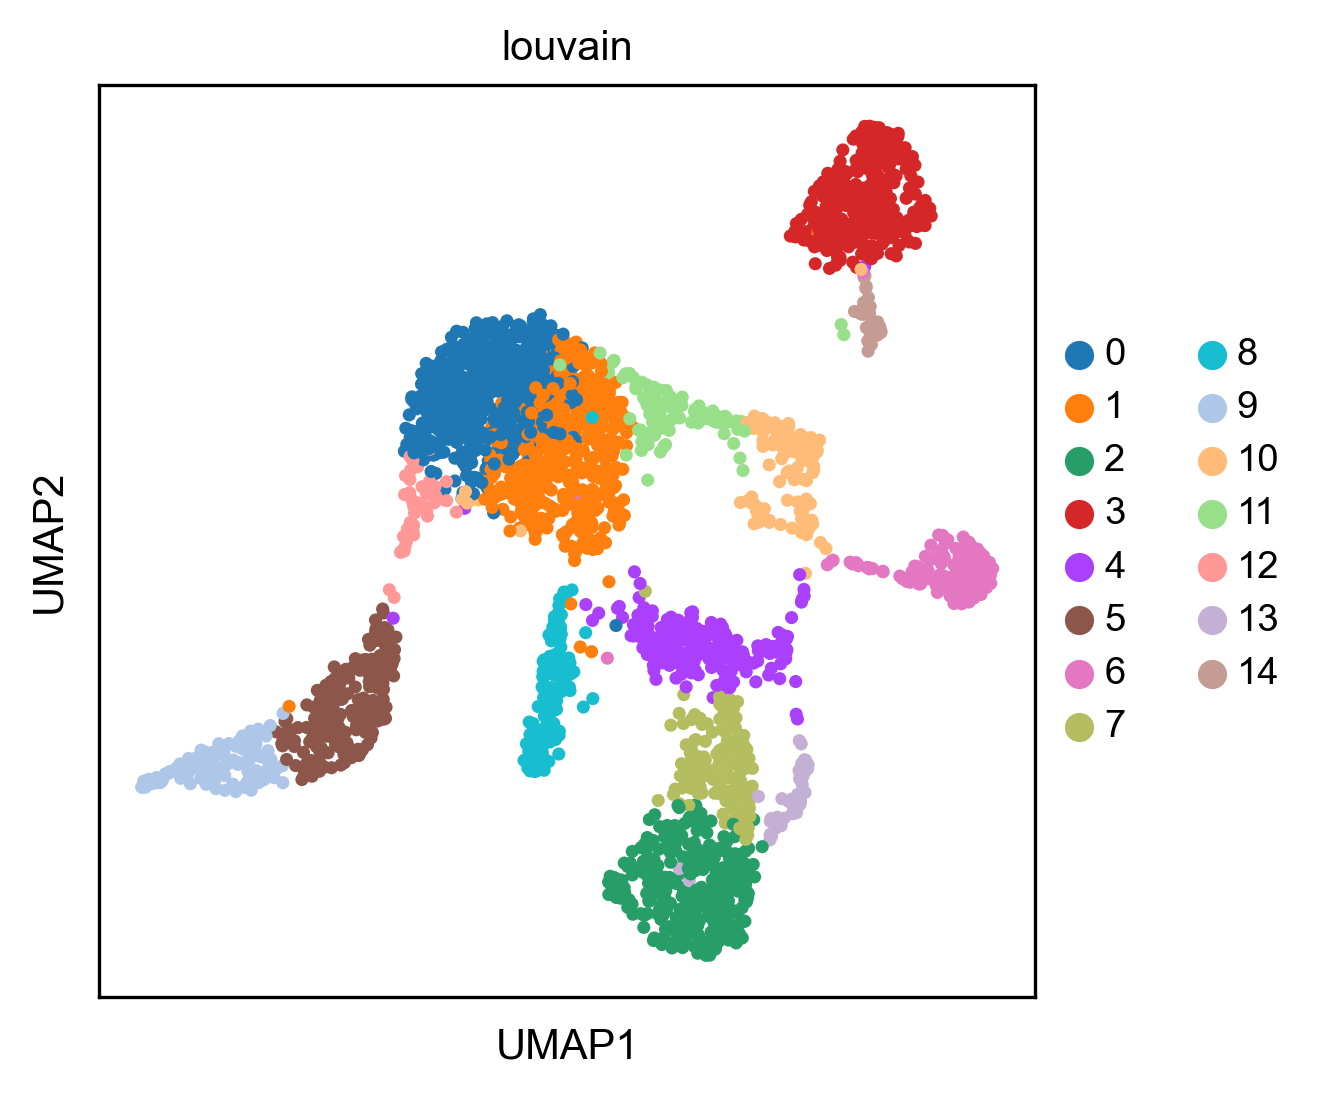

In [48]:
adata = sc.read_h5ad( '/Users/lidiayung/project/specimens/SF2979/gbm.h5ad' )
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])

In [85]:
adata = sc.read_h5ad( '/Users/lidiayung/project/specimens/SF2979/anndata.h5ad' )


In [86]:
adata

AnnData object with n_obs × n_vars = 3028 × 33694
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'

In [84]:
adata

AnnData object with n_obs × n_vars = 3028 × 4316
    obs: 'nGene', 'nUMI', 'percent_mito', 'n_counts', 'n_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors'
    obsm: 'X_pca'
    obsp: 'connectivities', 'distances'

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


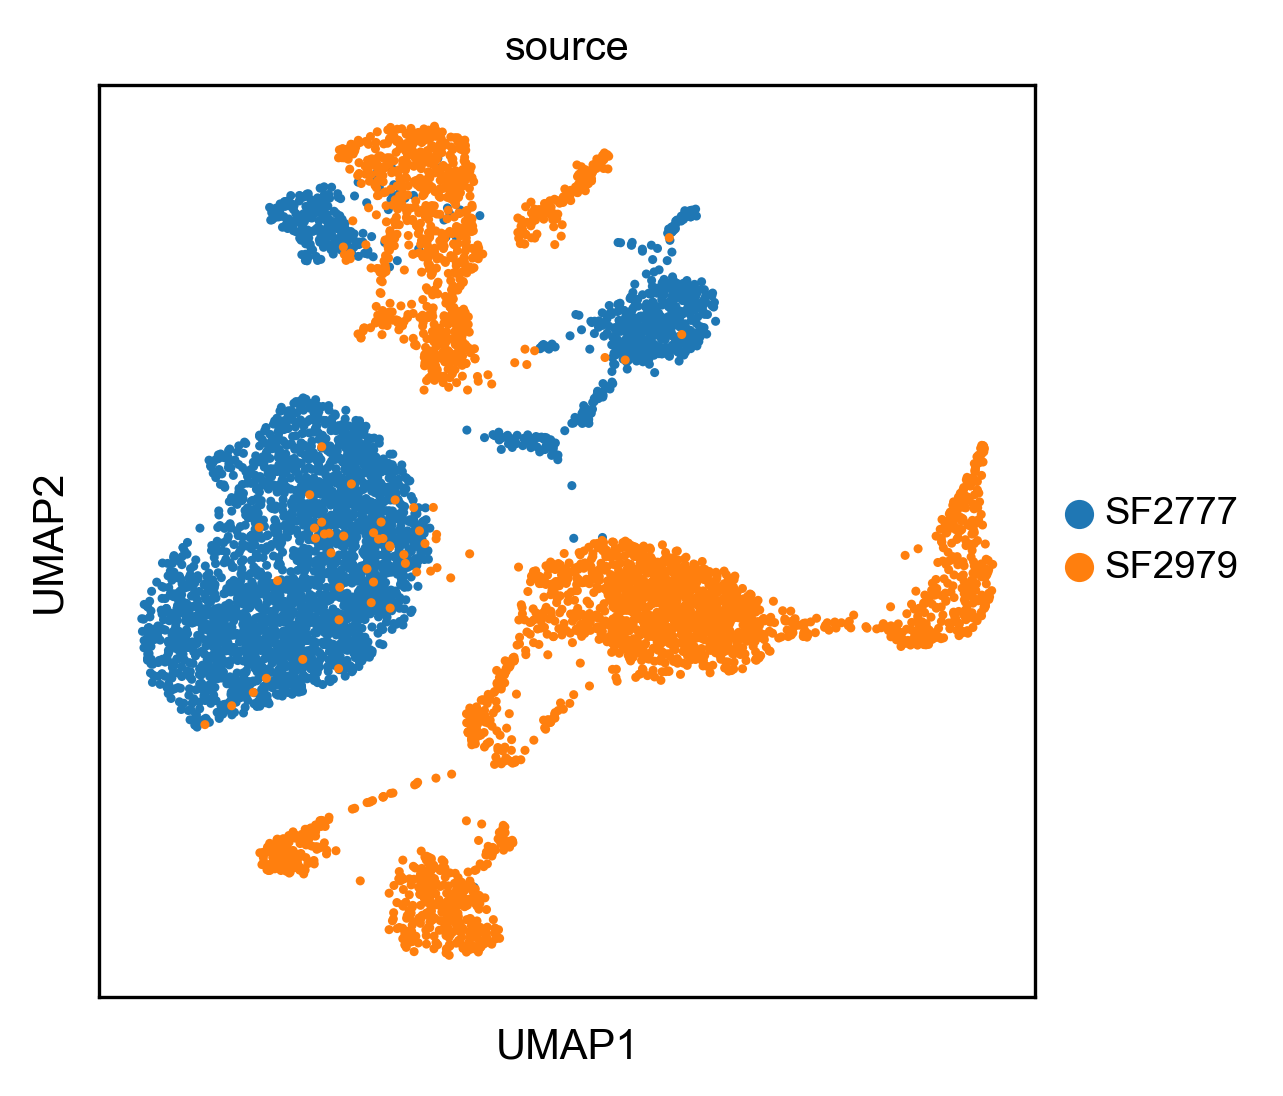

In [121]:
sample1='SF2777'
sample2='SF2979'
toplot(sample1,sample2)

In [120]:
#generate gene expression plots per sample
def toplot(sample1,sample2):
    input_folder = "/Users/lidiayung/project/specimens"
    input_path1 = os.path.join(input_folder, sample1) 
    input_path2 = os.path.join(input_folder, sample2) 
    
    f_anndata_path1 = f"{input_path1}/gbm.h5ad"
    f_anndata_path2 = f"{input_path2}/gbm.h5ad"
    
    
    adata1 = sc.read_h5ad(f_anndata_path1)
    adata2 = sc.read_h5ad(f_anndata_path2)
    
    adata1.obs['source'] = f"{sample1}"
    adata2.obs['source'] = f"{sample2}"

    # Merge the two objects into a single object
    adata = anndata.concat([adata1, adata2], index_unique=None, join='outer')
 
    color_dict = {f"{sample1}": 'blue', f"{sample2}": 'red'}
    adata.obs['color'] = adata.obs['source'].map(color_dict)

    sc.pp.neighbors(adata)
    
    
    #sc.tl.pca(adata, svd_solver='arpack')
    #sc.pl.pca_variance_ratio(adata, log=True)
    
    #umap
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['source'] )


   

In [114]:
# tSNE
    tsne = TSNE( n_jobs=8 )
    adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
    
    sc.tl.louvain(adata,resolution=0.4)

    sc.pl.umap(adata, color=['batch'], legend_loc='on data' )
    
    sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
    
    # sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
    # sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
    pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
    
    adata1.obs['source'] = f"{sample1}"
    adata2.obs['source'] = f"{sample2}"

    # Merge the two objects into a single object
    adata = adata1.concatenate(adata2, join='outer', batch_key='source')
    print(adata)
    color_dict = {f"{sample1}": 'blue', f"{sample2}": 'red'}
    adata.obs['color'] = adata.obs['source'].map(color_dict)
    
    
samples = ['SF3076','SF3243']
for sample in samples:
    readann(sample)

IndentationError: unexpected indent (3039490410.py, line 2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


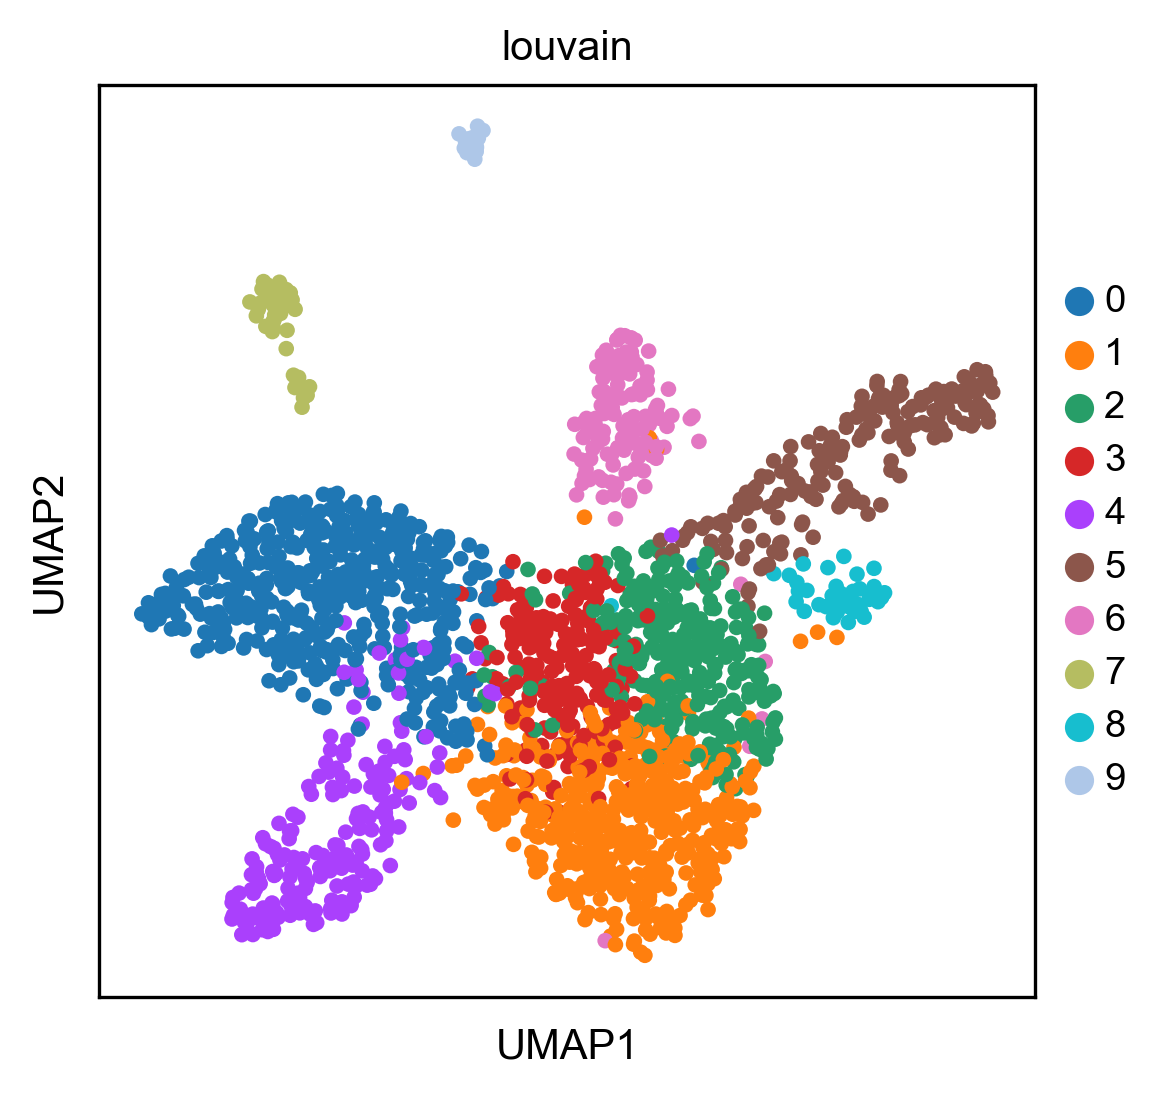

In [52]:
adata = sc.read_h5ad( '/Users/lidiayung/project/specimens/SF3243/gbm.h5ad' )
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])

/Users/lidiayung/project/specimens/SF11082
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 15
    using sklearn.manifold.TSNE


/Users/lidiayung/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


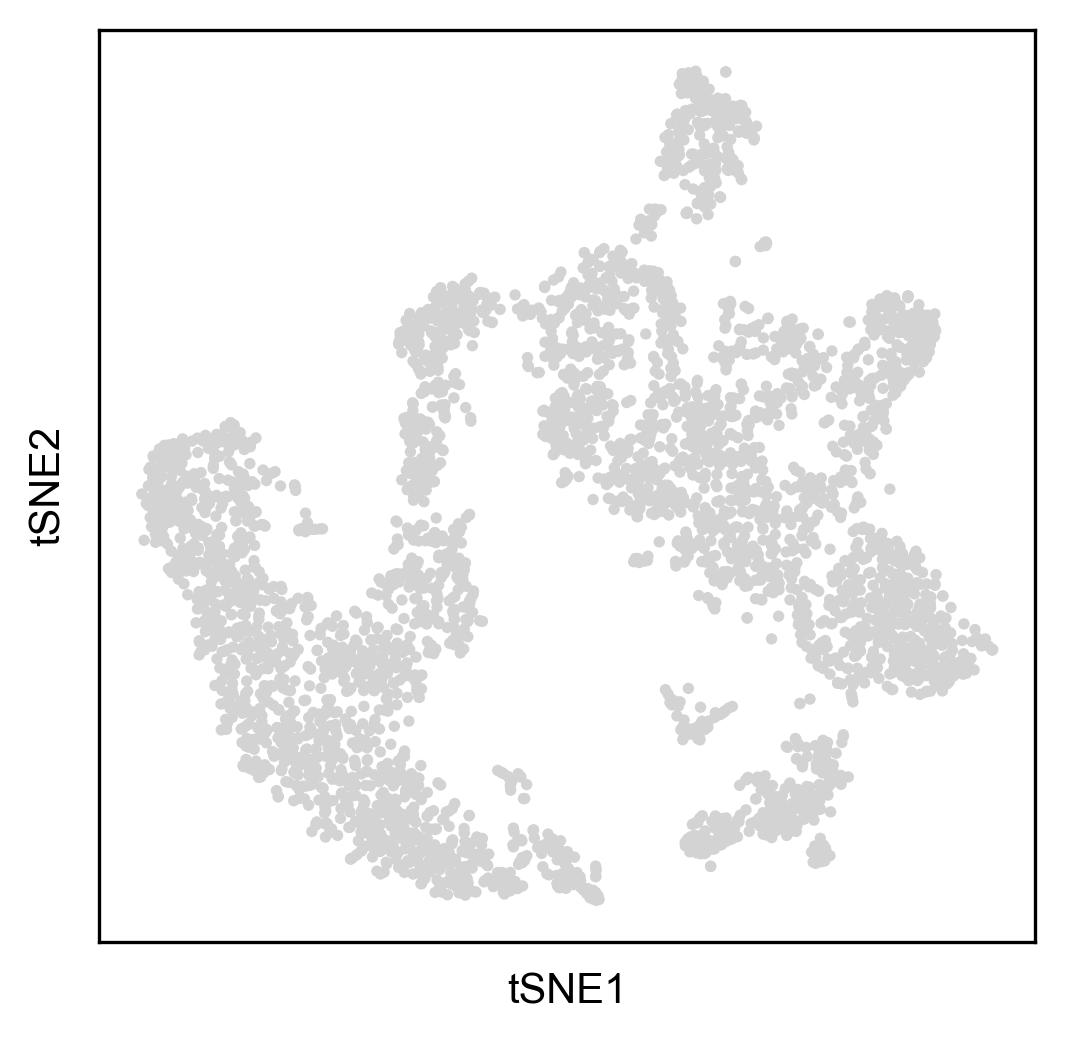

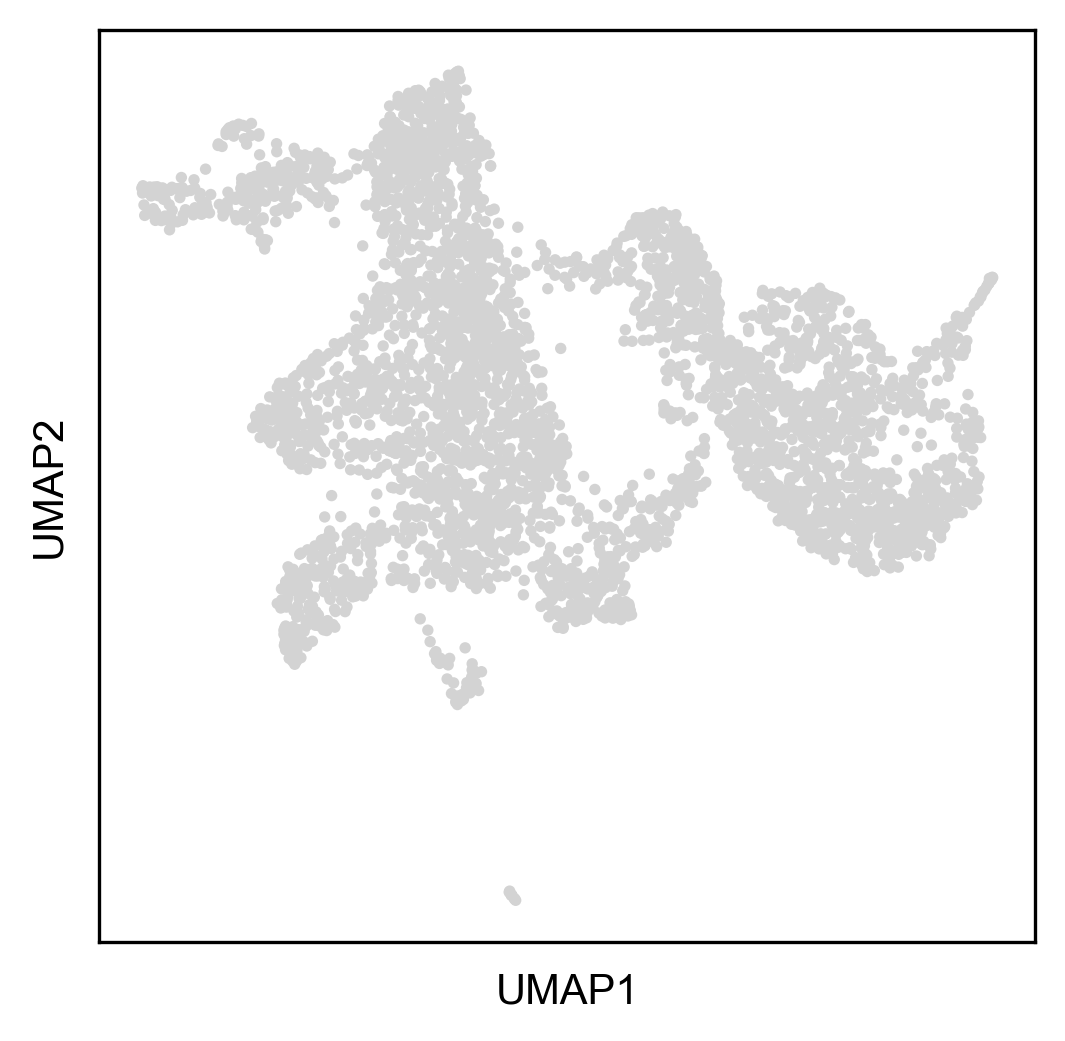

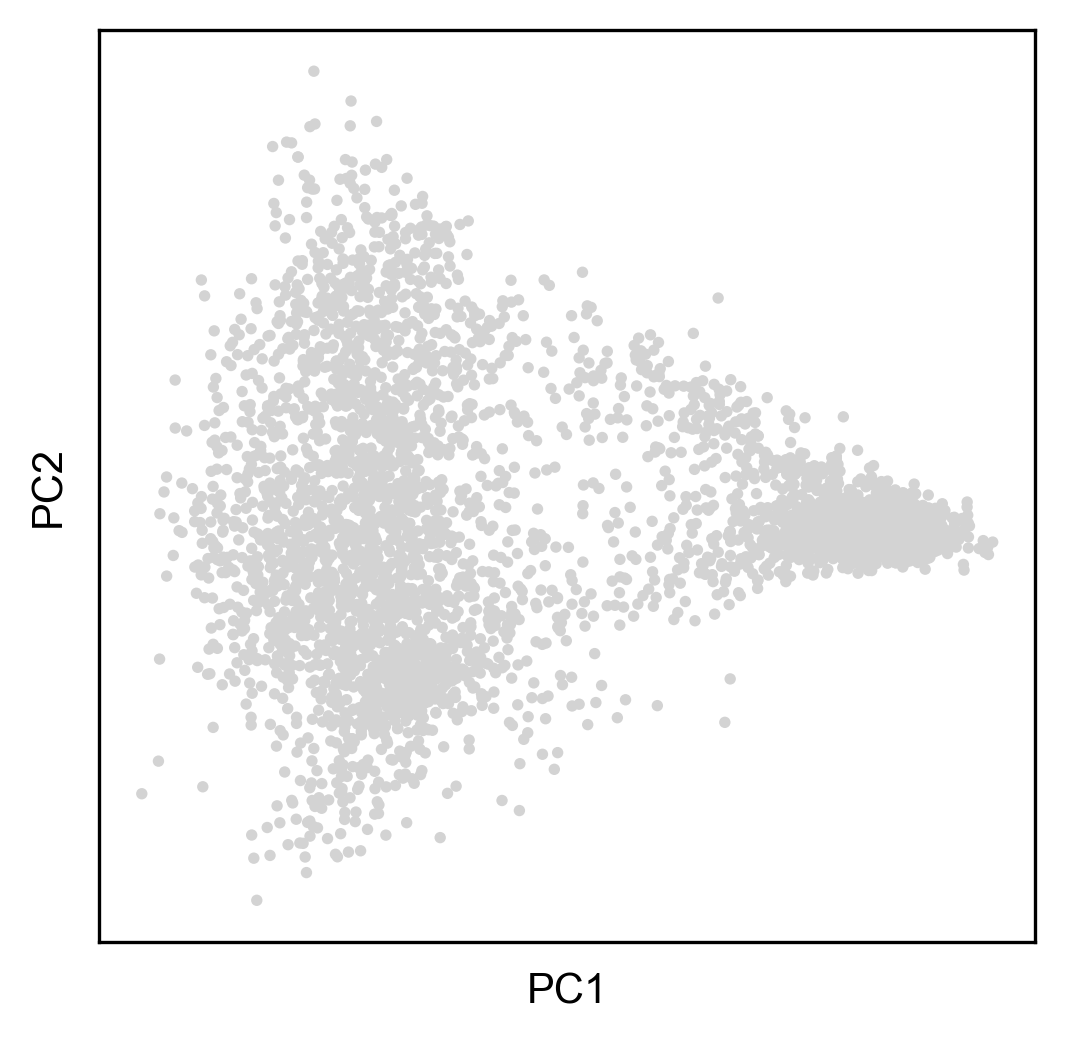

/Users/lidiayung/project/specimens/SF11488
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 15
    using sklearn.manifold.TSNE


/Users/lidiayung/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


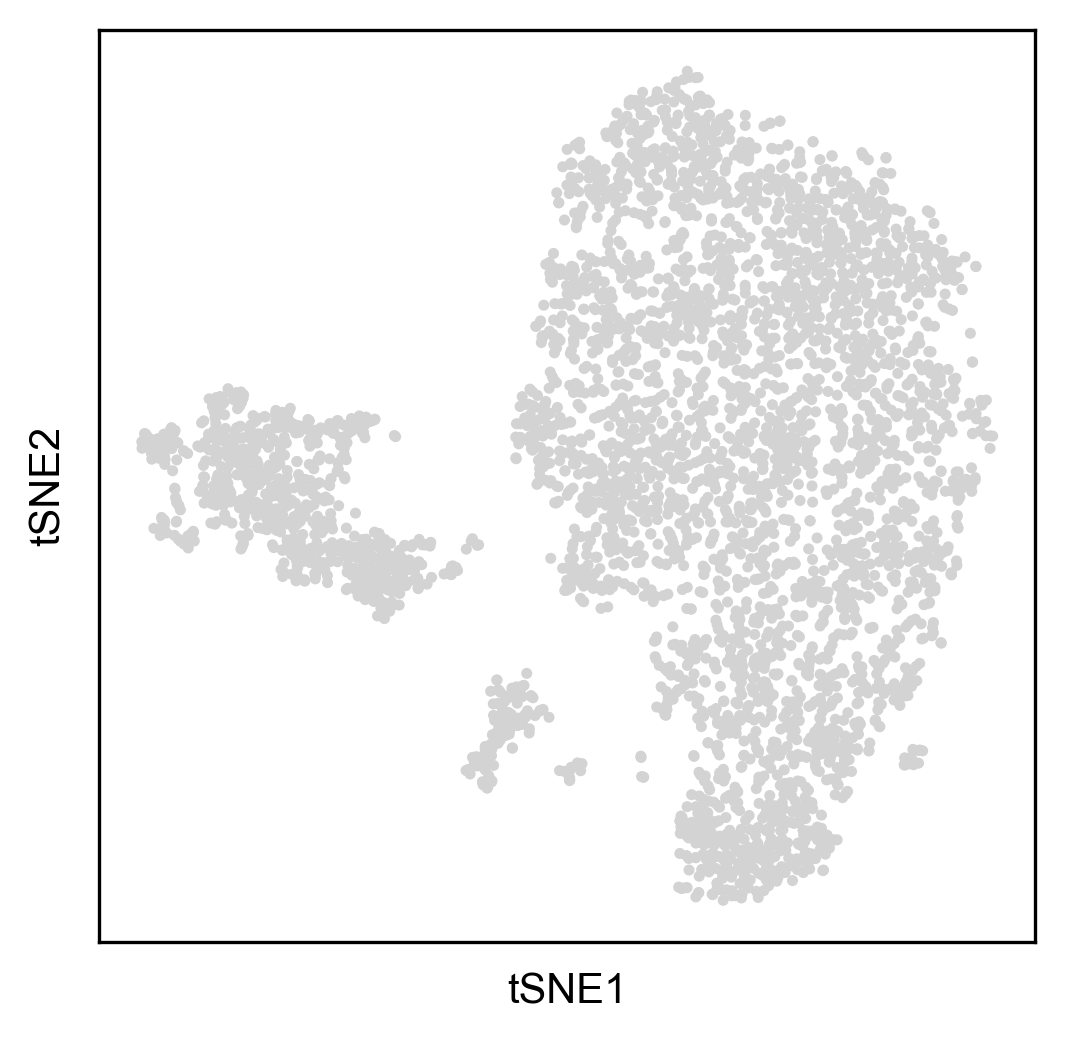

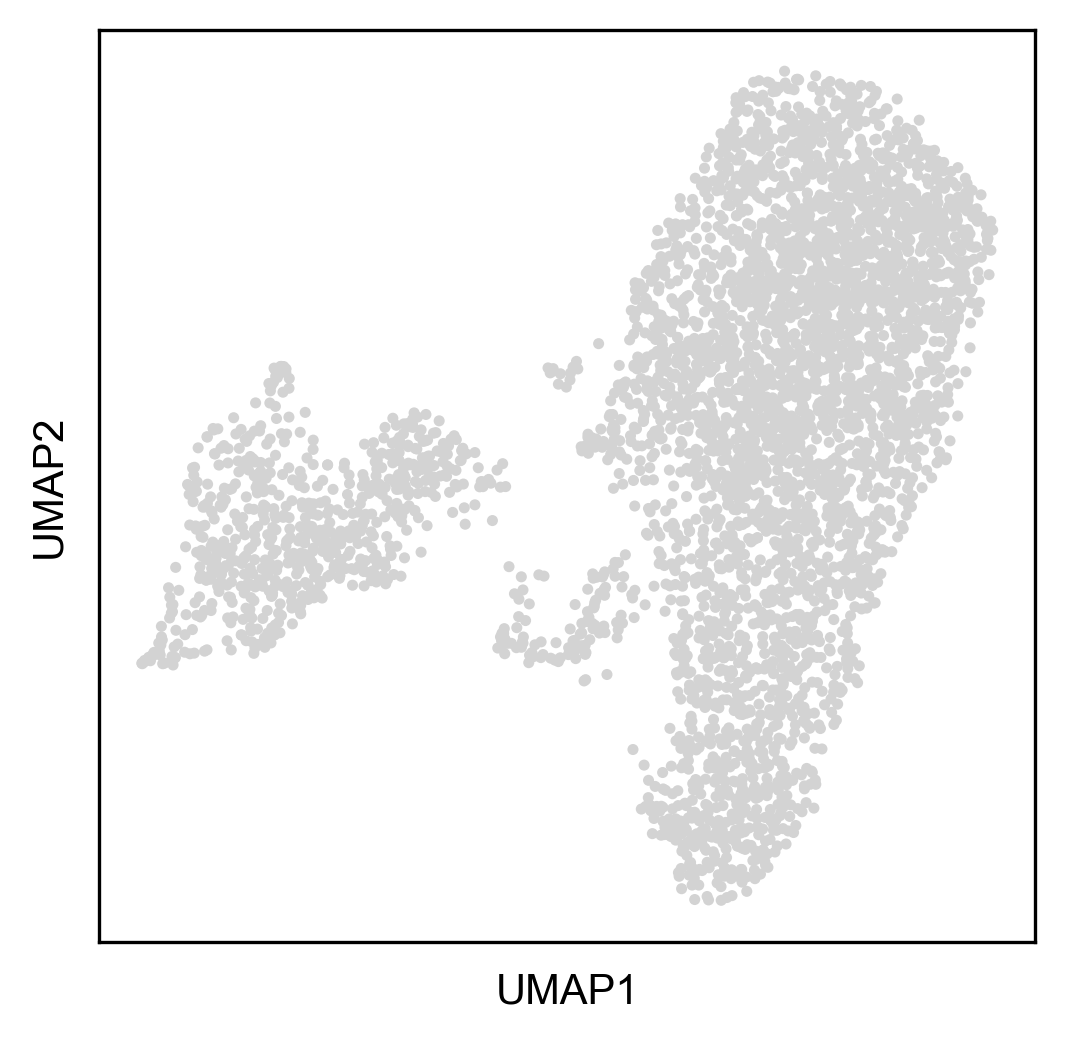

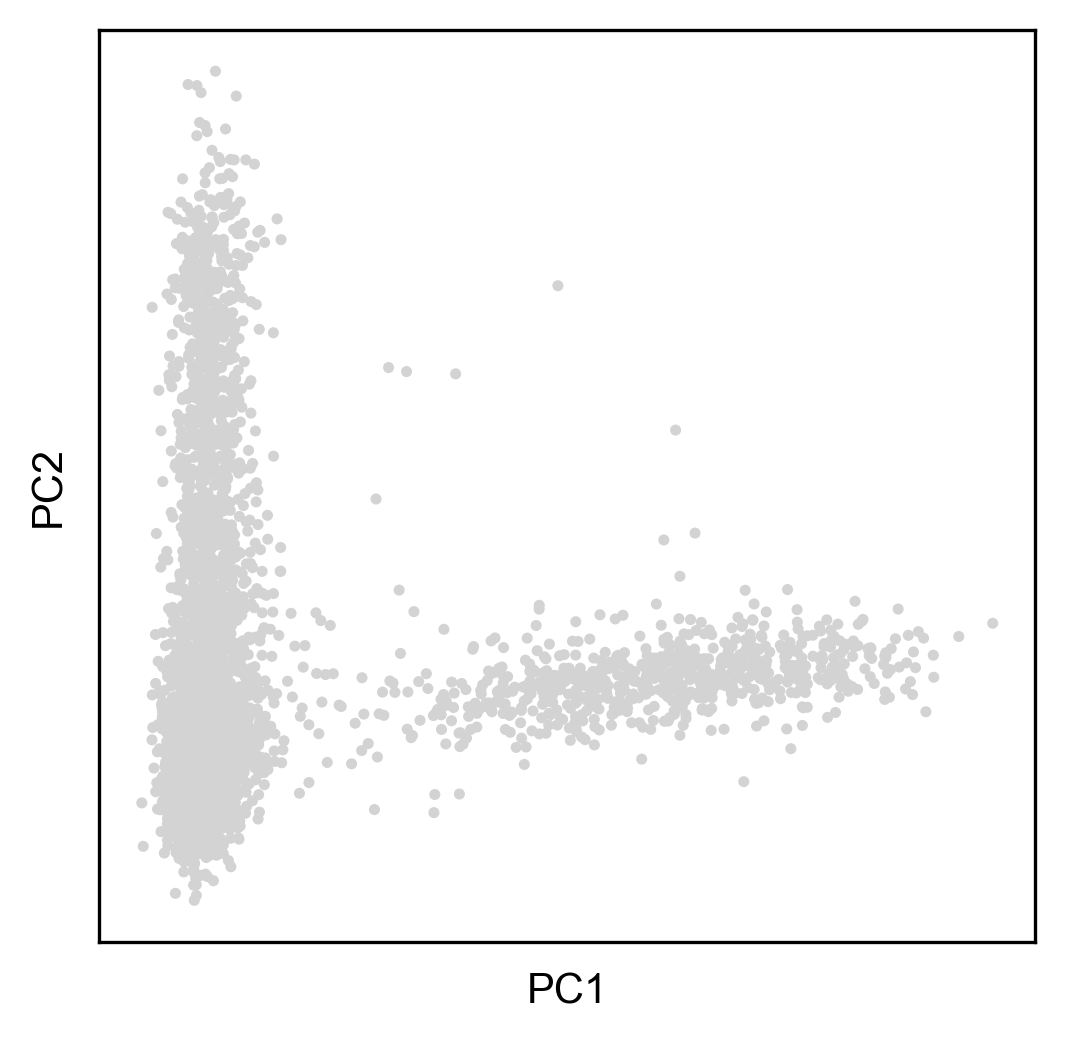

In [54]:
samples =['SF11082','SF11488']
for sample in samples:
    readann(sample)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


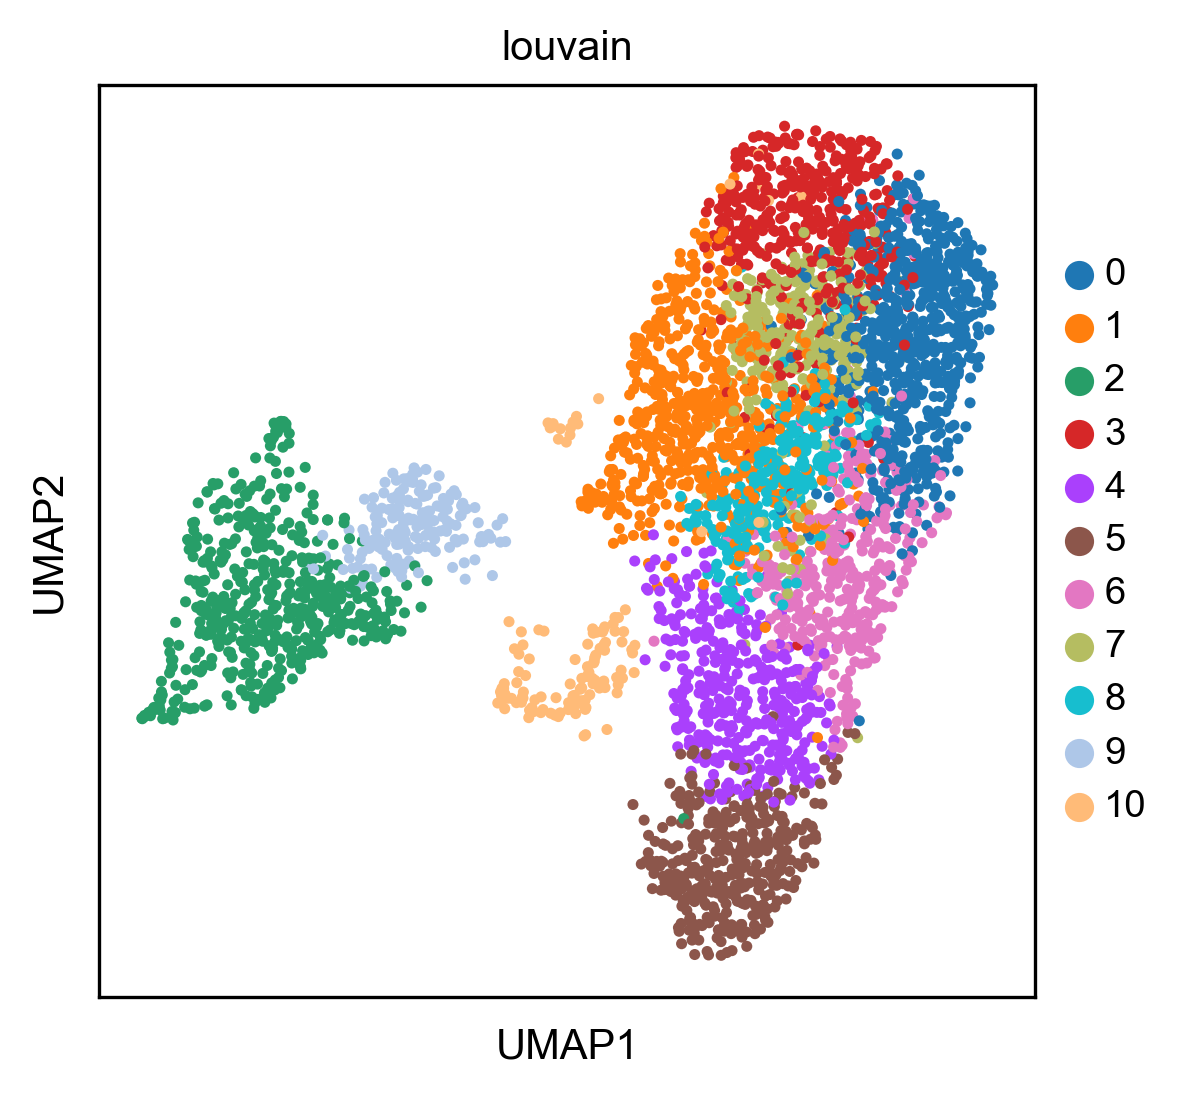

In [56]:
adata = sc.read_h5ad( '/Users/lidiayung/project/specimens/SF11488/gbm.h5ad' )
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])

computing PCA
    on highly variable genes
    with n_comps=50


/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


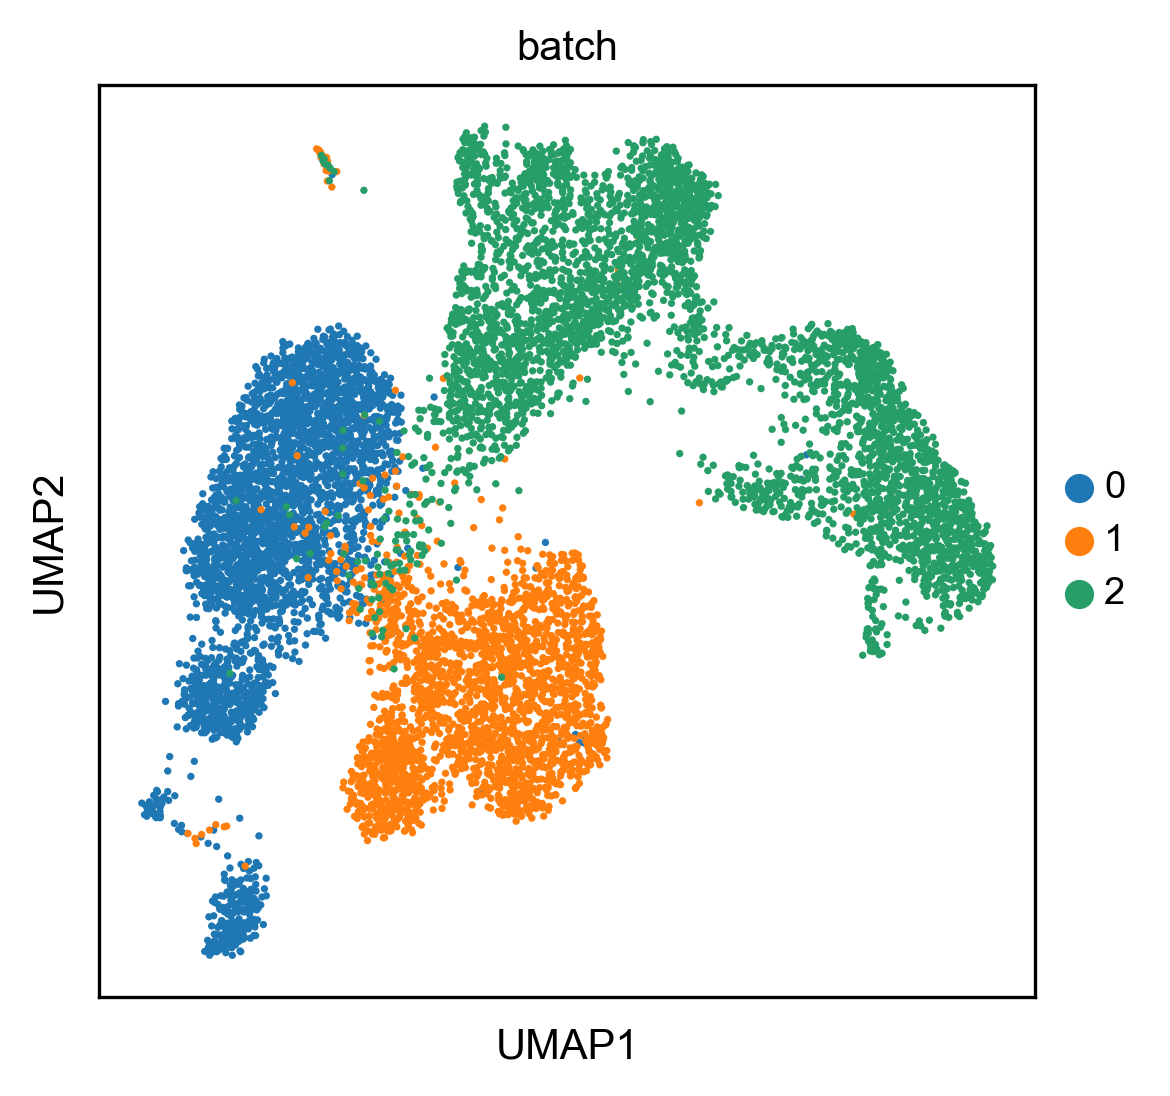

In [60]:
# Load the first dataset
adata1 = sc.read('/Users/lidiayung/project/specimens/SF2777/gbm.h5ad')

# Load the second dataset
adata2 = sc.read('/Users/lidiayung/project/specimens/SF3076/gbm.h5ad')

# Load the third dataset
adata3 = sc.read('/Users/lidiayung/project/specimens/SF11082/gbm.h5ad')

# Merge the three datasets
adata = adata1.concatenate(adata2, adata3)

# Perform PCA on the merged dataset
sc.tl.pca(adata)

# Perform UMAP on the merged dataset
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Plot the UMAP with cell colors based on the batches
sc.pl.umap(adata, color=['batch'])

computing PCA
    on highly variable genes
    with n_comps=50


/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


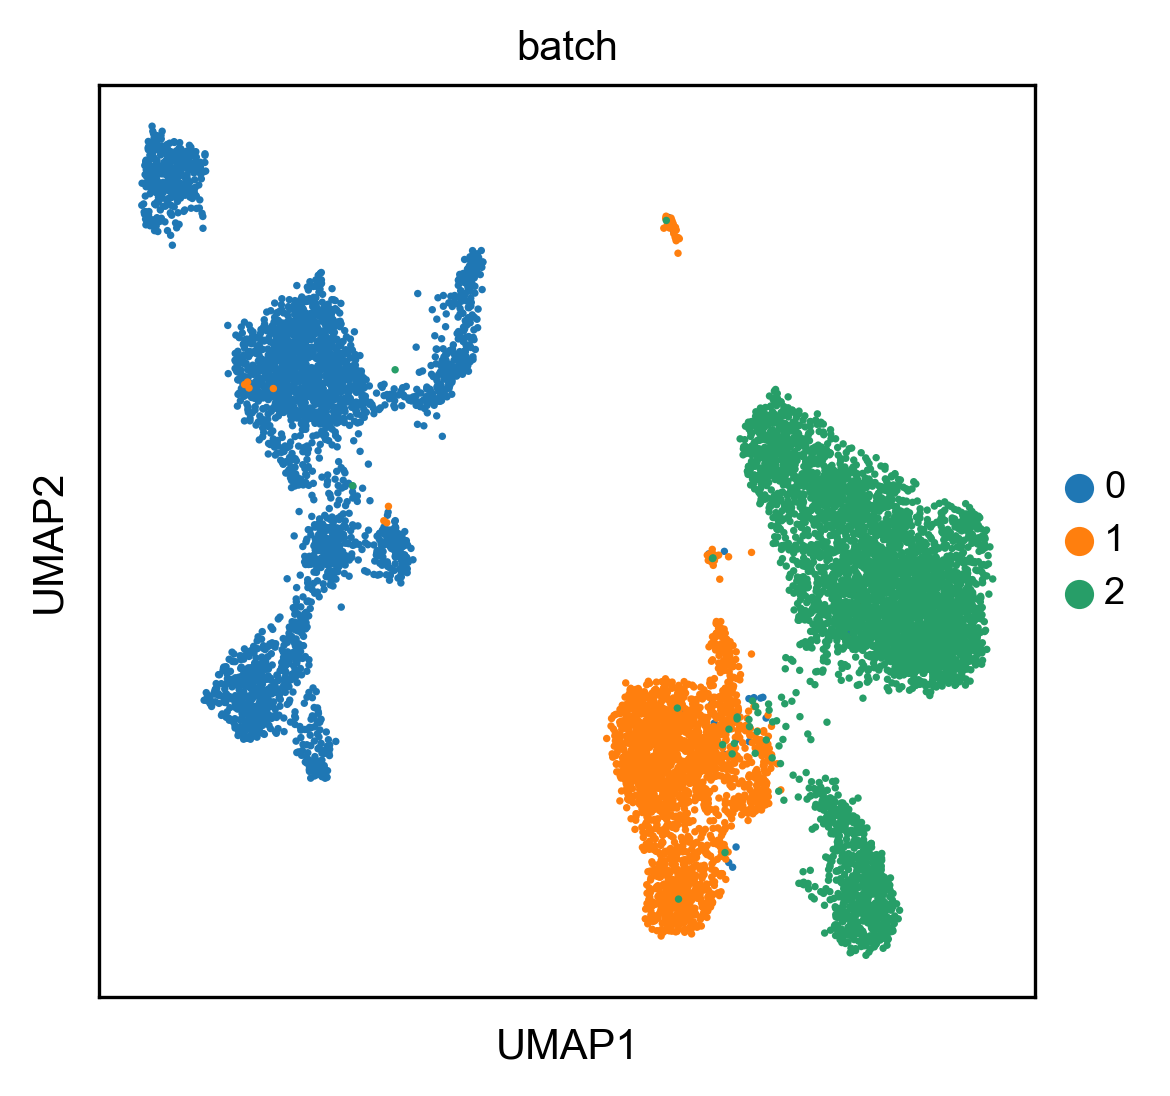

In [61]:
# Load the first dataset
adata1 = sc.read('/Users/lidiayung/project/specimens/SF2979/gbm.h5ad')

# Load the second dataset
adata2 = sc.read('/Users/lidiayung/project/specimens/SF3243/gbm.h5ad')

# Load the third dataset
adata3 = sc.read('/Users/lidiayung/project/specimens/SF11488/gbm.h5ad')

# Merge the three datasets
adata = adata1.concatenate(adata2, adata3)

# Perform PCA on the merged dataset
sc.tl.pca(adata)

# Perform UMAP on the merged dataset
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Plot the UMAP with cell colors based on the batches
sc.pl.umap(adata, color=['batch'])

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


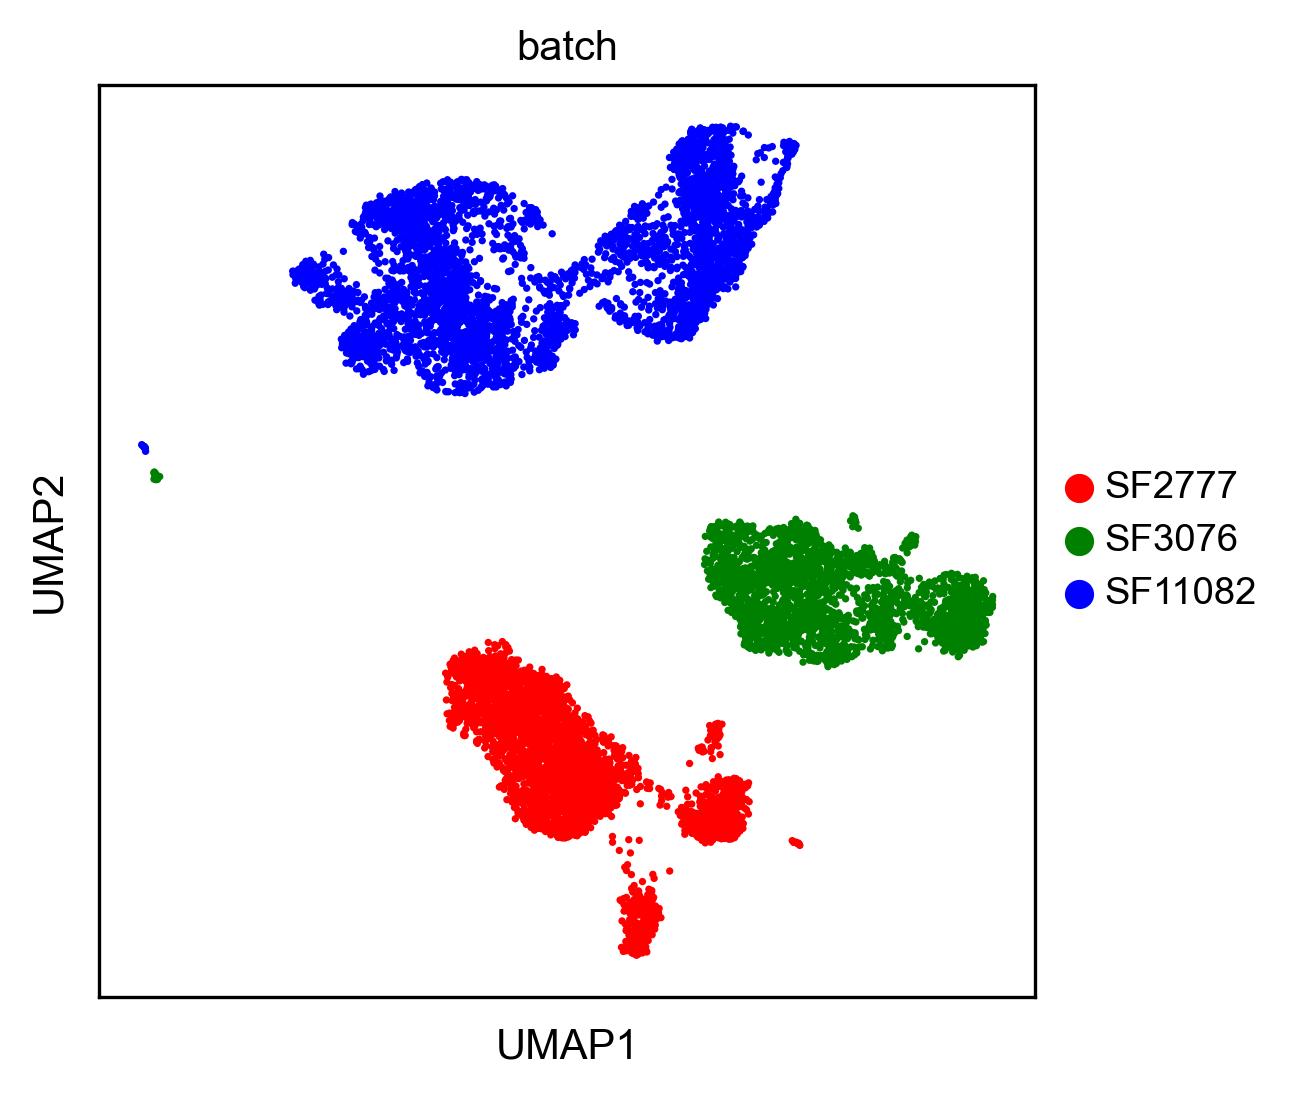

In [63]:
# Load the first dataset
adata1 = sc.read('/Users/lidiayung/project/specimens/SF2777/gbm.h5ad')

# Load the second dataset
adata2 = sc.read('/Users/lidiayung/project/specimens/SF3076/gbm.h5ad')

# Load the third dataset
adata3 = sc.read('/Users/lidiayung/project/specimens/SF11082/gbm.h5ad')

# Add a unique identifier to each dataset
adata1.obs['batch'] = 'SF2777'
adata2.obs['batch'] = 'SF3076'
adata3.obs['batch'] = 'SF11082'

# Merge the datasets
adata_merged = ad.concat([adata1, adata2, adata3], join='outer', index_unique='-')

# Run PCA
sc.tl.pca(adata_merged)

# Run UMAP
sc.pp.neighbors(adata_merged, n_neighbors=10)
sc.tl.umap(adata_merged)

# Assign colors to the samples
batch_colors = pd.Series({'SF2777': 'red', 'SF3076': 'green', 'SF11082': 'blue'})

adata_merged.obs['batch_color'] = adata_merged.obs['batch'].map(batch_colors)

unique_batches = adata_merged.obs['batch'].unique()
batch_colors_list = [batch_colors[b] for b in unique_batches]

# Add a batch_color column to adata_merged.obs
adata_merged.obs['batch_color'] = adata_merged.obs['batch'].map(batch_colors)

# Plot the UMAP with the batch colors
sc.pl.umap(adata_merged, color='batch', palette=batch_colors_list)


computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


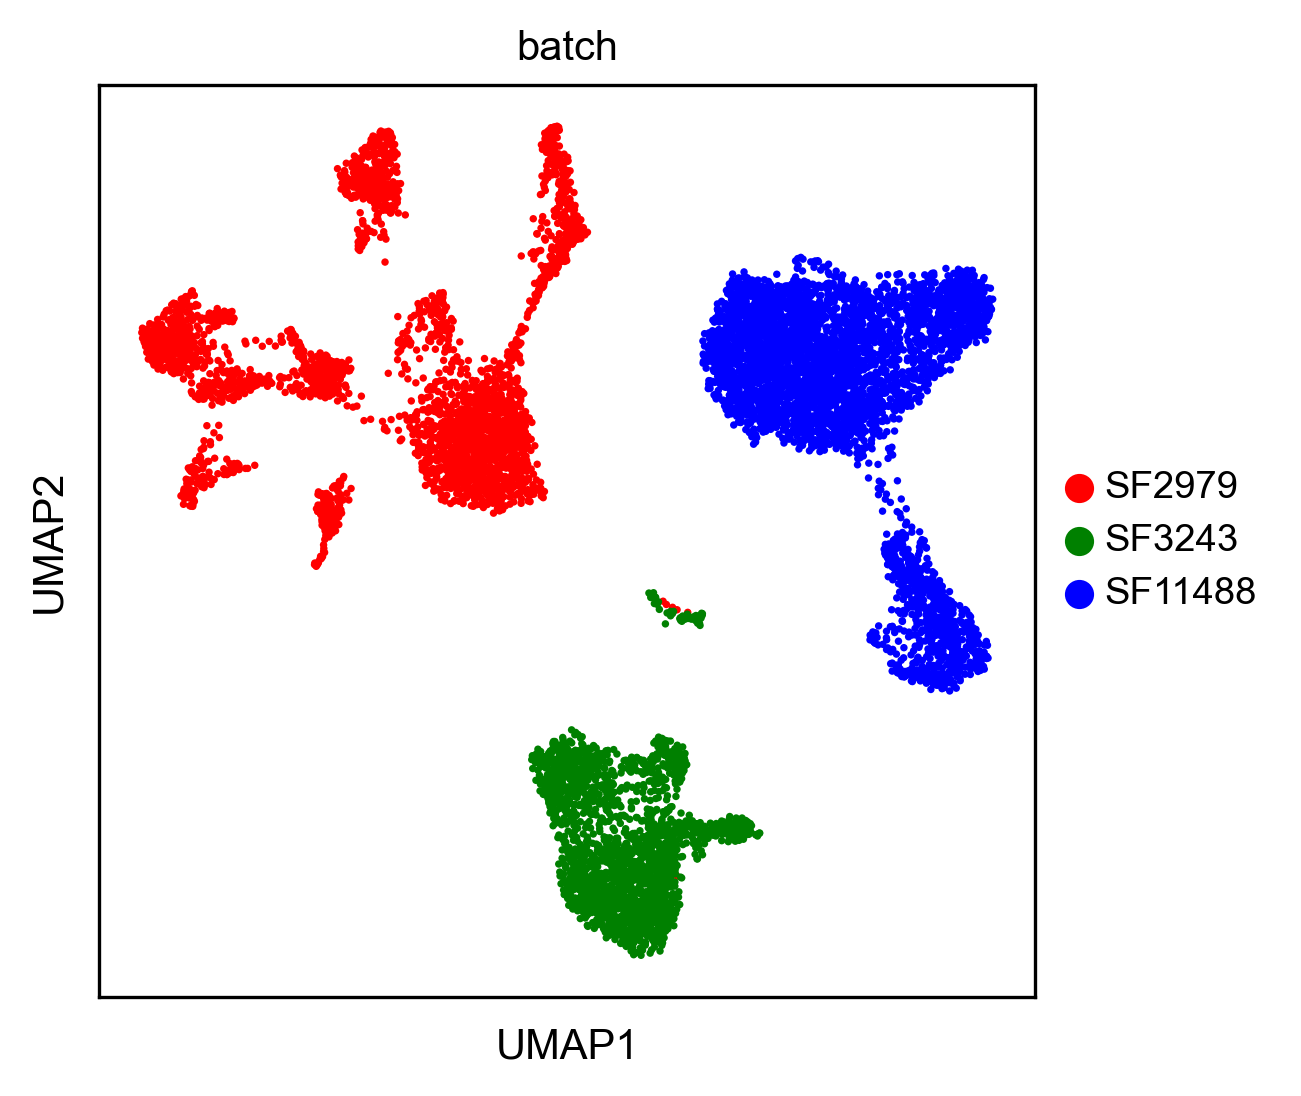

In [64]:
# Load the first dataset
adata1 = sc.read('/Users/lidiayung/project/specimens/SF2979/gbm.h5ad')

# Load the second dataset
adata2 = sc.read('/Users/lidiayung/project/specimens/SF3243/gbm.h5ad')

# Load the third dataset
adata3 = sc.read('/Users/lidiayung/project/specimens/SF11488/gbm.h5ad')

# Add a unique identifier to each dataset
adata1.obs['batch'] = 'SF2979'
adata2.obs['batch'] = 'SF3243'
adata3.obs['batch'] = 'SF11488'

# Merge the datasets
adata_merged = ad.concat([adata1, adata2, adata3], join='outer', index_unique='-')

# Run PCA
sc.tl.pca(adata_merged)

# Run UMAP
sc.pp.neighbors(adata_merged, n_neighbors=10)
sc.tl.umap(adata_merged)

# Assign colors to the samples
batch_colors = pd.Series({'SF2979': 'red', 'SF3243': 'green', 'SF11488': 'blue'})

adata_merged.obs['batch_color'] = adata_merged.obs['batch'].map(batch_colors)

unique_batches = adata_merged.obs['batch'].unique()
batch_colors_list = [batch_colors[b] for b in unique_batches]

# Add a batch_color column to adata_merged.obs
adata_merged.obs['batch_color'] = adata_merged.obs['batch'].map(batch_colors)

# Plot the UMAP with the batch colors
sc.pl.umap(adata_merged, color='batch', palette=batch_colors_list)


In [89]:
adata1_list = []
samples = ['SF2979', 'SF3243', 'SF11488']
for sample in samples:
    input_folder = "/Users/lidiayung/project/specimens"
    input_path = os.path.join(input_folder, sample) 
    
    f_anndata_path = f"{input_path}/gbm.h5ad"
    adata = sc.read_h5ad( f_anndata_path )
    
    adata1_list.append(adata)

adata2_list = []
samples =  ['SF2777', 'SF3076', 'SF11082']
for sample in samples:
    input_folder = "/Users/lidiayung/project/specimens"
    input_path = os.path.join(input_folder, sample) 
    
    f_anndata_path = f"{input_path}/gbm.h5ad"
    adata = sc.read_h5ad( f_anndata_path )
    
    adata2_list.append(adata)

# Merge the AnnData objects
adata_merged = ad.concat([adata1_list, adata1_list], join='outer', index_unique='-')

# Compute PCA and neighbors
sc.pp.pca(adata_merged, n_comps=50)
sc.pp.neighbors(adata_merged)

# Perform UMAP analysis
sc.tl.umap(adata_merged)

# Add batch information as observation annotation
adata_merged.obs['batch'] = adata_merged.obs['batch'].astype('category')

# Define color palette for each batch
batch_colors = {batch: color for batch, color in zip(samples, sns.color_palette('Set2', len(samples)))}

# Visualize the UMAP and color cells by batch
sc.pl.umap(adata_merged, color=['batch'], palette=batch_colors)


AttributeError: 'list' object has no attribute 'shape'

In [75]:

# Load the data from 6 separate files
# Load the first dataset
adata1 = sc.read('/Users/lidiayung/project/specimens/SF2979/gbm.h5ad')

# Load the second dataset
adata2 = sc.read('/Users/lidiayung/project/specimens/SF3243/gbm.h5ad')

# Load the third dataset
adata3 = sc.read('/Users/lidiayung/project/specimens/SF11488/gbm.h5ad')

# Load the first dataset
adata1 = sc.read('/Users/lidiayung/project/specimens/SF2777/gbm.h5ad')

# Load the second dataset
adata2 = sc.read('/Users/lidiayung/project/specimens/SF3076/gbm.h5ad')

# Load the third dataset
adata3 = sc.read('/Users/lidiayung/project/specimens/SF11082/gbm.h5ad')

# Set the batch names
batch_names = ['SF2979', 'SF3243', 'SF11488', 'SF2777', 'SF3076', 'SF11082']
filenames= ['adata1','adata2','adata3','adata4','adata5','adata6']


# Add a batch column to each object to keep track of which sample the cells came from
adata1.obs['batch'] = 'SF2979'
adata2.obs['batch'] = 'SF3243'
adata3.obs['batch'] = 'SF11488'
adata4.obs['batch'] = 'SF2777'
adata5.obs['batch'] = 'SF3076'
adata6.obs['batch'] = 'SF11082'

# Merge the AnnData objects
adata_list = [adata1, adata2, adata3, adata4, adata5, adata6]
adata_merged = anndata.AnnData.concatenate(adata_list, batch_key='batch', batch_categories=batch_names)

# Compute PCA and neighbors
sc.pp.pca(adata_merged, n_comps=50)
sc.pp.neighbors(adata_merged)

# Perform UMAP analysis
sc.tl.umap(adata_merged)

# Add batch information as observation annotation
adata_merged.obs['batch'] = adata_merged.obs['batch'].astype('category')

# Define color palette for each batch
batch_colors = {batch: color for batch, color in zip(batch_names, sns.color_palette('Set2', len(batch_names)))}

# Visualize the UMAP and color cells by batch
sc.pl.umap(adata_merged, color=['batch'], palette=batch_colors)




AttributeError: 'list' object has no attribute 'isbacked'

In [ ]:
def filtered(sample):
    input_folder = "/Users/lidiayung/project/specimens"
    input_path = os.path.join(input_folder, sample) 
    
    f_loom_path_scenic = "pbmc10k_filtered_scenic.loom" 
    
    f_anndata_path = f"{input_path}/anndata.h5ad"
    adata = sc.read_h5ad( f_anndata_path )
    
   
    
    return adata

    


In [75]:
# Create an empty dataframe to hold the merged data


def readdata(sample):
    
    input_folder = "/Users/lidiayung/project/specimens"
    input_path = os.path.join(input_folder, sample)
    results_file = f"{input_path}/gbm.h5ad"
    adata = sc.read_h5ad( results_file )

    return adata
    
samples=['SF2979', 'SF3243', 'SF11488', 'SF2777', 'SF3076', 'SF11082']

merged_df = pd.DataFrame()

# Loop through the sample directories
for sample in samples:
    readdata(sample)
    adata = readdata(sample)

    
    sample_df = pd.DataFrame(adata.obsm['X_pca'], columns=[f'{sample}_PC{i+1}' for i in range(15)])
    merged_df = pd.concat([merged_df, sample_df], axis=1)


   

In [21]:
merged_df.index = [idx.split('_')[0] for idx in merged_df.index]

In [15]:
merged_df.set_index(merged_df.columns[0], inplace=True)

In [59]:
merged_df.to_pickle('/Users/lidiayung/github/notebooks/GBM/calculation/merged_6.pkl')

In [76]:
merged_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256],
           dtype='int64', length=4257)

In [77]:
merged_df

,SF2979_PC1,SF2979_PC2,SF2979_PC3,SF2979_PC4,SF2979_PC5,SF2979_PC6,SF2979_PC7,SF2979_PC8,SF2979_PC9,SF2979_PC10,...,SF11082_PC6,SF11082_PC7,SF11082_PC8,SF11082_PC9,SF11082_PC10,SF11082_PC11,SF11082_PC12,SF11082_PC13,SF11082_PC14,SF11082_PC15
0,-73496.890625,-17756.638672,-36848.113281,-40534.386719,-3154.732666,-37205.007812,-17595.724609,35531.089844,-3523.012695,12683.500000,...,11082.838867,25874.609375,-11312.775391,8035.548340,31994.056641,-32173.158203,6371.632324,12169.395508,-9703.060547,15547.199219
1,-63250.937500,-6829.438477,-35151.671875,-42635.007812,-13397.368164,-3225.164062,-11540.709961,-3528.194336,6891.696289,-8646.080078,...,-19172.935547,-13987.575195,-3339.193115,6428.435059,-8783.115234,-2086.524902,8204.600586,1272.468018,14517.000977,-9377.771484
2,24496.816406,-32006.146484,-7485.125977,38879.058594,-81172.312500,27926.996094,-78590.187500,8688.676758,-41534.554688,30420.593750,...,19215.583984,55671.394531,-33571.367188,22792.066406,17355.160156,18242.443359,5812.137207,-14077.422852,-916.086975,18980.439453
3,-435.060669,-86323.671875,131103.937500,-16115.001953,-32810.796875,16214.799805,-20791.904297,10408.717773,-42279.855469,45850.859375,...,-6797.671387,-21931.369141,11408.925781,25490.177734,41092.531250,-14926.564453,19843.964844,38589.132812,6197.458984,-4450.515137
4,-20604.162109,-34505.812500,-18212.923828,35058.300781,-21339.562500,42979.246094,-80749.492188,-31814.886719,8942.792969,-72270.429688,...,36744.582031,16772.574219,15317.728516,11703.377930,22005.236328,-25016.417969,-384.188080,-27917.166016,21309.404297,32745.421875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
merged_= merged_df.transpose()

In [79]:
merged_

,0,1,2,3,4,5,6,7,8,9,...,4247,4248,4249,4250,4251,4252,4253,4254,4255,4256
SF2979_PC1,-73496.890625,-63250.937500,24496.816406,-435.060669,-20604.162109,-37062.929688,-59701.148438,219107.828125,-77587.859375,50489.800781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF2979_PC2,-17756.638672,-6829.438477,-32006.146484,-86323.671875,-34505.812500,-23731.748047,200934.656250,1513.768799,-28079.496094,-46105.304688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF2979_PC3,-36848.113281,-35151.671875,-7485.125977,131103.937500,-18212.923828,-18855.169922,41087.628906,-36378.394531,-42439.437500,-25347.931641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF2979_PC4,-40534.386719,-42635.007812,38879.058594,-16115.001953,35058.300781,22697.695312,12196.834961,-20174.787109,-47284.855469,16862.900391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF2979_PC5,-3154.732666,-13397.368164,-81172.312500,-32810.796875,-21339.562500,-24933.562500,-45875.113281,-39300.304688,-7284.614258,-66874.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SF11082_PC11,-32173.158203,-2086.524902,18242.443359,-14926.564453,-25016.417969,-2330.465576,-20358.906250,-29286.890625,-9963.679688,504.495575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF11082_PC12,6371.632324,8204.600586,5812.137207,19843.964844,-384.188080,-6002.976074,36592.070312,6674.909668,26573.298828,11392.698242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF11082_PC13,12169.395508,1272.468018,-14077.422852,38589.132812,-27917.166016,47166.945312,-39141.632812,-32449.681641,-26770.371094,7958.722656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF11082_PC14,-9703.060547,14517.000977,-916.086975,6197.458984,21309.404297,24094.619141,-26561.482422,-6563.810059,37643.203125,21773.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
from sklearn.decomposition import PCA
merged_df=pd.read_pickle('/Users/lidiayung/github/notebooks/GBM/calculation/merged_6.pkl')


In [36]:

merged_df=merged_df.fillna(merged_df.mean())
pca= PCA(n_components=2)
pca.fit(merged_df)

                           
transformed = pca.transform(merged_df)

In [39]:
transformed.shape

(90, 2)

In [46]:
pca_data = pd.DataFrame(transformed)
pca_data.insert(0,"sampleID",merged_df.index)


In [47]:
pca_data

,sampleID,0,1
0,SF2979,-207271.671875,93839.453125
1,SF2979,212716.531250,-431768.031250
2,SF2979,-100528.304688,-6243.860840
3,SF2979,-190677.812500,-59826.425781
4,SF2979,-105853.789062,-71601.828125
...,...,...,...
85,SF11082,-85495.218750,-83339.015625
86,SF11082,-92153.351562,-52894.531250
87,SF11082,-79023.226562,-111402.539062
88,SF11082,-72096.101562,-163093.093750


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

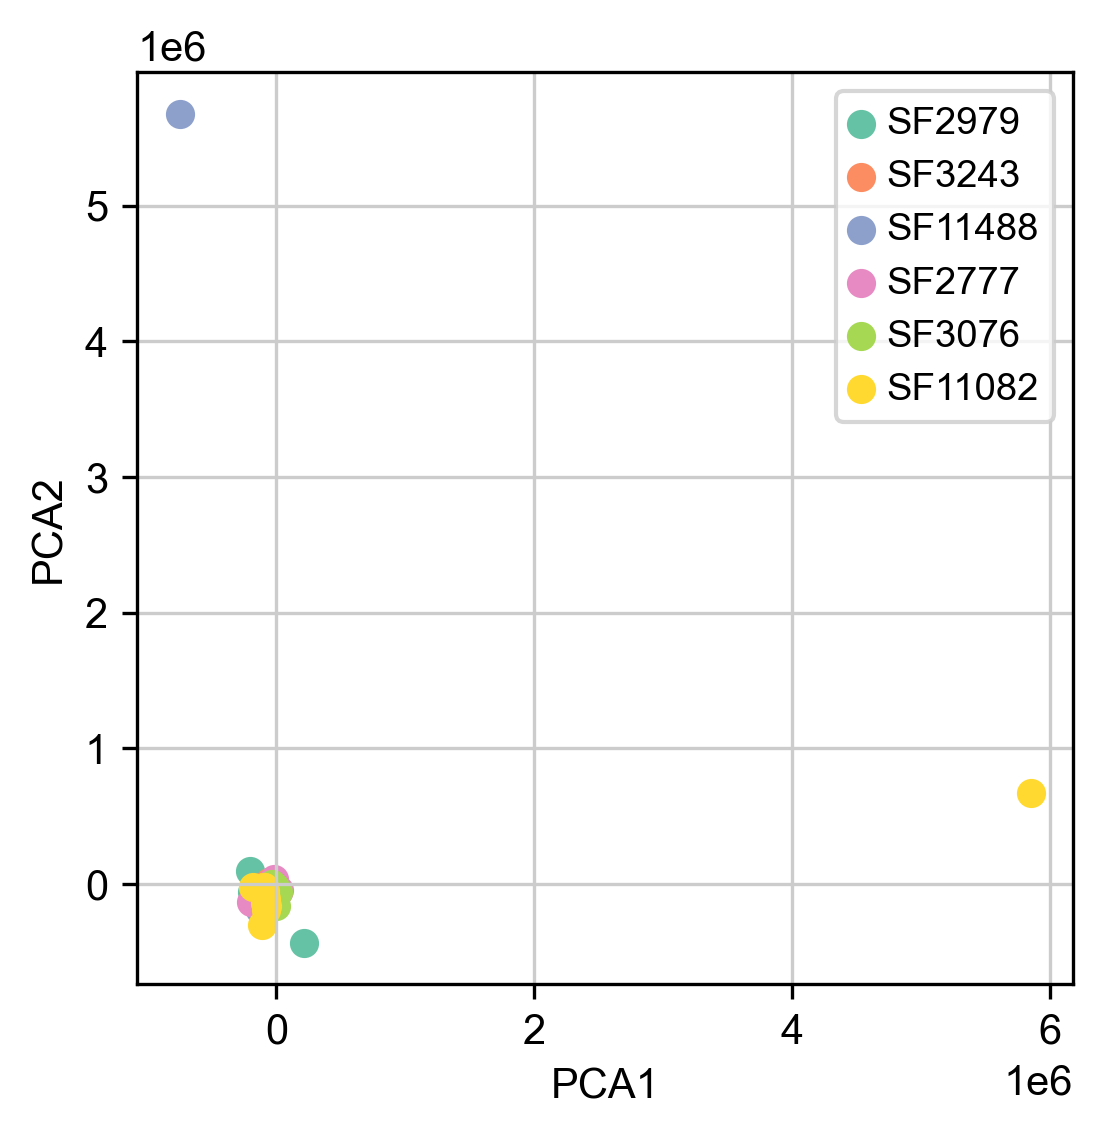

In [52]:
samples=['SF2979', 'SF3243', 'SF11488', 'SF2777', 'SF3076', 'SF11082']

batch_colors = {sample: color for sample, 
                color in zip(samples, sns.color_palette('Set2', len(samples)))}

for element in samples:
    x = pca_data.loc[pca_data["sampleID"]== element][0]
    y = pca_data.loc[pca_data["sampleID"]== element][1]
    plt.scatter(x, y,c=batch_colors[element],label=str(element))   
plt.legend()
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()